In [1]:
import pandas as pd
import numpy as np
import wrds
import re
import requests
from fredapi import Fred
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from dotenv import load_dotenv
import os
import warnings
import joblib

In [13]:
#==============================================================================
# CACHE UTILITY FUNCTIONS
# Save/load expensive computations to avoid re-running long training cells
#==============================================================================

from pathlib import Path

# Create cache directory
CACHE_DIR = Path("./model_cache")
CACHE_DIR.mkdir(exist_ok=True)

def save_checkpoint(obj, name, description=""):
    """Save an object to cache using joblib."""
    path = CACHE_DIR / f"{name}.joblib"
    joblib.dump(obj, path)
    print(f"✓ Saved {name}: {description}")
    
def load_checkpoint(name):
    """Load an object from cache."""
    path = CACHE_DIR / f"{name}.joblib"
    if path.exists():
        obj = joblib.load(path)
        print(f"✓ Loaded {name} from cache")
        return obj
    else:
        print(f"✗ Cache not found: {name}")
        return None

def checkpoint_exists(name):
    """Check if a checkpoint exists."""
    return (CACHE_DIR / f"{name}.joblib").exists()

def list_checkpoints():
    """List all available checkpoints."""
    checkpoints = list(CACHE_DIR.glob("*.joblib"))
    if checkpoints:
        print("Available checkpoints:")
        for cp in checkpoints:
            size_mb = cp.stat().st_size / (1024 * 1024)
            print(f"  - {cp.stem} ({size_mb:.1f} MB)")
    else:
        print("No checkpoints found")
    return [cp.stem for cp in checkpoints]

def clear_checkpoint(name):
    """Delete a specific checkpoint."""
    path = CACHE_DIR / f"{name}.joblib"
    if path.exists():
        path.unlink()
        print(f"✓ Deleted checkpoint: {name}")
    else:
        print(f"✗ Checkpoint not found: {name}")

print(f"Cache directory: {CACHE_DIR.absolute()}")
list_checkpoints()


Cache directory: c:\Users\nils\OneDrive\Desktop\UCLA\Spring Quarter 2025\Thesis Work\SDF-Research\model_cache
Available checkpoints:
  - combined_sdf (0.0 MB)
  - lstm_long_models (2.2 MB)
  - lstm_short_models (4.7 MB)
  - model_predictions (25.1 MB)
  - non_lstm_models (745.7 MB)
  - sdf_results (0.0 MB)


['combined_sdf',
 'lstm_long_models',
 'lstm_short_models',
 'model_predictions',
 'non_lstm_models',
 'sdf_results']

### Old OG Data Collection

In [ ]:
conn = wrds.Connection(wrds_username="nberzins")

In [4]:
conn.describe_table(library= "crsp", table='dsf')

Approximately 107663472 rows in crsp.dsf.


,name,nullable,type,comment
0,cusip,True,VARCHAR(8),CUSIP Header
1,permno,True,INTEGER,PERMNO
2,permco,True,INTEGER,PERMCO
3,issuno,True,INTEGER,Nasdaq Issue Number
4,hexcd,True,SMALLINT,Exchange Code Header
5,hsiccd,True,INTEGER,Standard Industrial Classification Code Header
6,date,True,DATE,Date of Observation
7,bidlo,True,"NUMERIC(11, 5)",Bid or Low Price
8,askhi,True,"NUMERIC(11, 5)",Ask or High Price
9,prc,True,"NUMERIC(11, 5)",Price or Bid/Ask Average


In [33]:
sp500 = conn.raw_sql("""
                        SELECT a.*, b.date, b.ret, b.prc, b.shrout
                        FROM crsp.dsp500list as a, crsp.dsf as b
                        WHERE a.permno=b.permno
                            AND b.date >= a.start and b.date <= a.ending
                            AND b.date >= '01/01/2000'
                        ORDER BY date; 
                        """, date_cols=['start', 'ending', 'date'])

In [40]:
sp500["mktcap"] = np.absolute(sp500["prc"]) * sp500["shrout"]

In [41]:
dse = conn.raw_sql("""
                        SELECT comnam, namedt, nameendt, permno, siccd
                        FROM crsp.dsenames
                        """, date_cols=['namedt', 'nameendt'])

dse['Major Group'] = dse['siccd'] // 100

In [42]:
sic_groups = pd.read_csv("SIC_Major_Groups.csv")

dse = pd.merge(dse, sic_groups, how='left', on='Major Group')

In [43]:
fama_five = conn.raw_sql("""
                            SELECT *
                            FROM ff.fivefactors_daily as ff
                            WHERE ff.date >= '01/01/2000'
                            """)

fama_five["date"] = pd.to_datetime(fama_five["date"], format='%Y-%m-%d')

fama_five.tail(5)

,date,mktrf,smb,hml,rmw,cma,rf,umd
6284,2024-12-24,0.0111,-0.0012,-0.0005,-0.0013,-0.0037,0.00017,0.0067
6285,2024-12-26,0.0002,0.0109,-0.0019,-0.0044,0.0035,0.00017,0.0001
6286,2024-12-27,-0.0117,-0.0044,0.0056,0.0041,0.0003,0.00017,-0.0088
6287,2024-12-30,-0.0109,0.0024,0.0074,0.0055,0.0014,0.00017,0.0006
6288,2024-12-31,-0.0046,0.0031,0.0071,0.0033,0.0,0.00017,-0.0107


In [44]:
load_dotenv()

fred_api_key = os.getenv("FRED_API_KEY")

fred = Fred(api_key = fred_api_key)
fed_funds = fred.get_series('FEDFUNDS', observation_start='2000-01-01', observation_ends='2024-01-12')

In [45]:
ffer_df = fed_funds.to_frame(name="fed_funds_rate").reset_index()

ffer_df.describe()
ffer_df = ffer_df.rename(columns={"index": "date", "fed_funds_rate": "fed_funds_rate"})

ffer_df["date"] = pd.to_datetime(ffer_df["date"], format="%Y-%d-%m")
ffer_df["date"] = ffer_df["date"].dt.strftime('%Y-%m-%d')
ffer_df["date"] = pd.to_datetime(ffer_df["date"], format="%Y-%m-%d")

ffer_df = ffer_df[:-4]
ffer_df["fed_funds_rate"] = ffer_df["fed_funds_rate"] / 100
ffer_df

,date,fed_funds_rate
0,2000-01-01,0.0545
1,2000-02-01,0.0573
2,2000-03-01,0.0585
3,2000-04-01,0.0602
4,2000-05-01,0.0627
...,...,...
295,2024-08-01,0.0533
296,2024-09-01,0.0513
297,2024-10-01,0.0483
298,2024-11-01,0.0464


In [46]:
#Merging returns w/ company info

sp500_full = pd.merge(sp500, dse, how='left', on='permno')
sp500_full = sp500_full.loc[(sp500_full.date>=sp500_full.namedt) \
                             & (sp500_full.date<=sp500_full.nameendt)]

# Merging fama french factors and complete sp500 data

sp500_full = pd.merge(sp500_full, fama_five, how='left', on='date')

#Merging Federal Funds Rate Data 
#because only working with monthly values, have to break up the data into year and month then join on those two columns

sp500_full["month"] = sp500_full["date"].dt.month
sp500_full["year"] = sp500_full["date"].dt.year

ffer_df["month"] = ffer_df["date"].dt.month
ffer_df["year"] = ffer_df["date"].dt.year

#getting rid of unneccesary date column to avoid repeat column naames post-merge
ffer_df = ffer_df.drop(columns=["date"])

sp500_full = pd.merge(sp500_full, ffer_df, on=["year","month"], how="left")

# Removing now unnecessary month/year columns & repeat
sp500_full = sp500_full.drop(columns=["month", "year"])


In [47]:
# Date str --> Datetime conversion
sp500_full["date"] = pd.to_datetime(sp500_full["date"], format='%Y-%m-%d')

# ret, mktrf, smb, etc. --> log returns conversion
# Log-returns prove additive and will not impact future return-based factor calculations

cols_to_log = ["ret", "mktrf", "smb", "hml", "rmw", "cma", "rf", "fed_funds_rate"]
sp500_full[cols_to_log] = np.log1p(sp500_full[cols_to_log])

In [48]:
sp500_full

,permno,start,ending,date,ret,prc,shrout,mktcap,comnam,namedt,...,Major Group,Group Name,mktrf,smb,hml,rmw,cma,rf,umd,fed_funds_rate
0,14322,1925-12-31,2005-03-24,2000-01-03,-0.010341,30.0625,377954.0,11362242.125,SEARS ROEBUCK & CO,1968-01-02,...,53,General Merchandise Stores,-0.007125,-0.0006,-0.0142,-0.015114,-0.006421,0.00021,-0.0008,0.053067
1,59184,1976-07-01,2008-11-18,2000-01-03,-0.012423,70.0,465290.0,32570300.0,ANHEUSER BUSCH COS INC,1980-04-18,...,20,Food And Kindred Products,-0.007125,-0.0006,-0.0142,-0.015114,-0.006421,0.00021,-0.0008,0.053067
2,12650,1999-04-05,2000-07-12,2000-01-03,-0.056862,70.5,110524.0,7791942.0,KANSAS CITY SOUTHERN INDS INC,1968-01-02,...,40,Railroad Transportation,-0.007125,-0.0006,-0.0142,-0.015114,-0.006421,0.00021,-0.0008,0.053067
3,76887,1999-08-02,2008-12-04,2000-01-03,-0.043485,8.4375,188848.0,1593405.0,ALLIED WASTE INDUSTRIES INC,1998-12-30,...,49,"Electric, Gas, And Sanitary Services",-0.007125,-0.0006,-0.0142,-0.015114,-0.006421,0.00021,-0.0008,0.053067
4,42534,1986-05-08,2016-09-02,2000-01-03,-0.016621,55.9375,85404.0,4777286.25,JOHNSON CONTROLS INC,1974-12-02,...,38,"Measuring, Analyzing, And Controlling Instrume...",-0.007125,-0.0006,-0.0142,-0.015114,-0.006421,0.00021,-0.0008,0.053067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3155298,20057,2020-11-17,2024-12-31,2024-12-31,0.005638,12.45,1193593.0,14860232.85,VIATRIS INC,2021-03-25,...,99,Nonclassifiable Establishments,-0.004611,0.003095,0.007075,0.003295,0.0,0.00017,-0.0107,0.043825
3155299,76744,2013-09-23,2024-12-31,2024-12-31,0.008354,402.70001,257529.0,103706930.87529,VERTEX PHARMACEUTICALS INC,2004-06-10,...,28,Chemicals And Allied Products,-0.004611,0.003095,0.007075,0.003295,0.0,0.00017,-0.0107,0.043825
3155300,27959,1976-07-01,2024-12-31,2024-12-31,0.000279,107.74,772482.0,83227210.68,DUKE ENERGY CORP NEW,2014-02-03,...,49,"Electric, Gas, And Sanitary Services",-0.004611,0.003095,0.007075,0.003295,0.0,0.00017,-0.0107,0.043825
3155301,85913,1998-05-21,2024-12-31,2024-12-31,-0.004899,278.94,277893.0,77515473.42,MARRIOTT INTERNATIONAL INC NEW,2013-10-21,...,70,"Hotels, Rooming Houses, Camps, And Other Lodgi...",-0.004611,0.003095,0.007075,0.003295,0.0,0.00017,-0.0107,0.043825


**Store Data As CSV to avoid long pull request times from WRDS**

In [4]:
# sp500_full.to_csv("sp500_full.csv", index = False)

sp500_full = pd.read_csv("sp500_full.csv")
sp500_full["date"] = pd.to_datetime(sp500_full["date"])
sp500_full = sp500_full.dropna()

### Notable Industry Codes
- 50-59 = General Retail
- 60 = Depository Institutions (Banking)
- 63 = Insurance Carriers
- 73 = Business Services (Tech)
- 80 = Health Services

In [5]:
# MUST BE: "Daily", "Weekly", or "Monthly"

def get_anomalies(time_frame="Monthly"):

    anomalies_dict = {}

    parent_path = f"./Anomaly Factors/{time_frame}/"
    
    folders = os.listdir(parent_path)
    
    for folder in folders:
        #get parent folder path
        path = f"{parent_path}{folder}/"
        files = os.listdir(path)
    
        for file in files:
            #get file path       
            file_path = f"{path}{file}"
            
            #get raw data
            df = pd.read_csv(file_path)

            if time_frame == "Daily":
    
                #Handilng Date Column
                df["DATE"] = pd.to_datetime(df['DATE'].astype(str), format='%Y%m%d')
                df = df[df["DATE"] >= pd.to_datetime("2000-01-01")]
        
                #getting rank and ret column names
                rank_col = df.columns[1]
                ret_col = df.columns[3]
        
                # #### High Minus Low Spread Return ####
        
                # # Selecting Rows only where the decile is either 1 or 10 
                # d10 = df[df[rank_col] == 10][["DATE", ret_col]].rename(columns={ret_col: "D10"})
                # d1 = df[df[rank_col] == 1][["DATE", ret_col]].rename(columns={ret_col: "D1"})
        
                # # Merge and compute spread
                # df_filt = pd.merge(d10, d1, on="DATE")
                # df_filt["HML_ret"] = df_filt["D10"] - df_filt["D1"]
        
                #### Average of Deciles ####
        
                df_filt = df.groupby("DATE")[ret_col].mean().reset_index(name = "DecileMean_Ret") 
                df_filt[f"log_{ret_col}"] = np.log1p(df_filt["DecileMean_Ret"] / 100) #ensuring log returns for consistency/mutability
        
                #### Rank-Weighted Return ####
        
                # A proxy for linear factor return
                
                #### Count-Weighted Return ####
        
                # Handling that some deciles are calculated from fewer or greater securities than others for every given day

                match = re.search(r"^portf(.*?)_daily_2024\.csv", file)
                anomaly_name = match.group(1).lstrip("_")
                
                anomalies_dict[anomaly_name] = df_filt

            elif time_frame == "Weekly":
                # NOT CURRENTLY WORKING WITH WEEKLY
                pass
            else: #Monthly

                #Handilng Date Column
                df["DATE"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))
                df['DATE'] = pd.to_datetime(df['DATE'])
                df = df[df['DATE'] >= pd.to_datetime("2000-01-01")]

                #Dropping unnecessary columns for readability, then moving DATE to replicate the daily format
                df.drop(columns = ["year", "month"], inplace = True)
                cols = ["DATE"] + [col for col in df.columns if col != "DATE"]
                
                df = df[cols]

                  
                #getting rank and ret column names
                rank_col = df.columns[1]
                ret_col = df.columns[3]
        
                # #### High Minus Low Spread Return ####
        
                # # Selecting Rows only where the decile is either 1 or 10 
                # d10 = df[df[rank_col] == 10][["DATE", ret_col]].rename(columns={ret_col: "D10"})
                # d1 = df[df[rank_col] == 1][["DATE", ret_col]].rename(columns={ret_col: "D1"})
        
                # # Merge and compute spread
                # df_filt = pd.merge(d10, d1, on="DATE")
                # df_filt["HML_ret"] = df_filt["D10"] - df_filt["D1"]
        
                #### Average of Deciles ####
        
                df_filt = df.groupby("DATE")[ret_col].mean().reset_index(name = "DecileMean_Ret") 
                df_filt[f"log_{ret_col}"] = np.log1p(df_filt["DecileMean_Ret"] / 100) #ensuring log returns for consistency/mutability
        
                #### Rank-Weighted Return ####
        
                # A proxy for linear factor return
                
                #### Count-Weighted Return ####
        
                # Handling that some deciles are calculated from fewer or greater securities than others for every given day
    
                match = re.search(r"^portf(.*?)_monthly_2024\.csv", file)
                anomaly_name = match.group(1).lstrip("_")
                
                anomalies_dict[anomaly_name] = df_filt

    return anomalies_dict

### Daily Dictionaries

#### Obtaining Daily Anomaly Portfolios

In [6]:
anomalies_daily_dict = get_anomalies("Daily")

In [7]:
warnings.filterwarnings("ignore")

first_key = next(iter(anomalies_daily_dict))
merged_anomalies = anomalies_daily_dict[first_key][["DATE"]].copy()

for key, df in anomalies_daily_dict.items():

    log_col = [col for col in df.columns if col.startswith("log_")][0]

    merged_anomalies[key] = df[log_col].values

merged_anomalies["DATE"] = pd.to_datetime(merged_anomalies["DATE"])

#### Daily SP500 Returns

In [8]:
# Calculating Volatility

sp500_full["volatility_21d"] = (
    sp500_full.groupby("comnam")["ret"]
    .rolling(window=21, min_periods=1)
    .std()
    .reset_index(level=0, drop = True)
    .fillna(0))

# Calculating 5 day Short-term reversal

sp500_full["5d_reversal"] = -(
    sp500_full.groupby("comnam")["ret"]
    .rolling(window=5, min_periods=1)
    .sum()
    .reset_index(level=0, drop=True)
    .fillna(0)

)

# Calculating 1 day lagged short-term reversal

sp500_full["1d_lag_reversal"] = -(
    sp500_full.groupby("comnam")["ret"].shift(1)
    .fillna(0)
)

#### Merging SP500 Daily with Anomalies and Converting to Dictionary

In [9]:
sp500_anom = sp500_full.merge(merged_anomalies, how = "left", left_on = "date", right_on = "DATE")
sp500_anom.drop(columns=["DATE"], inplace = True)

In [10]:
factor_cols = sp500_anom.columns.tolist()[14:]

sp500_dly = {
    name: group[["date", "Major Group", "ret"] +factor_cols].reset_index(drop=True)
    for name, group in sp500_anom.groupby("comnam")
}

sp500_dly["ALPHABET INC"]

#CHECK REPEAT ROWS ISSUE

,date,Major Group,ret,mktrf,smb,hml,rmw,cma,rf,umd,...,op,rev_12,rev_1,rev_6,spq_12,spq_1,spq_6,sp,vfp,vhp
0,2015-10-05,73,0.022114,0.019116,0.007373,0.007671,0.001099,0.005982,0.00000,-0.0196,...,0.019661,0.020344,0.021064,0.020290,0.021294,0.021562,0.021222,0.021115,0.020171,0.019226
1,2015-10-05,73,0.022959,0.019116,0.007373,0.007671,0.001099,0.005982,0.00000,-0.0196,...,0.019661,0.020344,0.021064,0.020290,0.021294,0.021562,0.021222,0.021115,0.020171,0.019226
2,2015-10-06,73,0.006170,-0.004309,-0.000900,0.016365,0.003394,0.005485,0.00000,-0.0306,...,-0.004012,-0.002014,-0.001542,-0.001927,-0.002831,-0.002369,-0.003144,-0.002390,-0.002121,-0.003087
3,2015-10-06,73,-0.000060,-0.004309,-0.000900,0.016365,0.003394,0.005485,0.00000,-0.0306,...,-0.004012,-0.002014,-0.001542,-0.001927,-0.002831,-0.002369,-0.003144,-0.002390,-0.002121,-0.003087
4,2015-10-07,73,-0.002445,0.009356,0.007770,-0.002403,-0.001301,0.001000,0.00000,-0.0033,...,0.010420,0.009828,0.010261,0.009924,0.010092,0.010876,0.010359,0.009864,0.009979,0.009648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4647,2024-12-27,73,-0.015647,-0.011769,-0.004410,0.005584,0.004092,0.000300,0.00017,-0.0088,...,-0.010181,-0.009715,-0.009348,-0.009543,-0.008525,-0.008462,-0.008468,-0.008812,-0.008446,-0.009265
4648,2024-12-30,73,-0.007916,-0.010960,0.002397,0.007373,0.005485,0.001399,0.00017,0.0006,...,-0.010175,-0.010637,-0.010962,-0.010762,-0.009766,-0.009814,-0.009804,-0.009683,-0.010295,-0.009392
4649,2024-12-30,73,-0.006981,-0.010960,0.002397,0.007373,0.005485,0.001399,0.00017,0.0006,...,-0.010175,-0.010637,-0.010962,-0.010762,-0.009766,-0.009814,-0.009804,-0.009683,-0.010295,-0.009392
4650,2024-12-31,73,-0.011746,-0.004611,0.003095,0.007075,0.003295,0.000000,0.00017,-0.0107,...,-0.002926,-0.001593,-0.001022,-0.001504,0.001189,0.001212,0.001333,0.000645,0.000044,-0.001351


### Weekly Dictionaries

#### Obtaining Weekly Anomaly Portfolios

#### Weekly SP500 Returns

In [5]:
factor_cols = ["ret", "mktrf", "smb", "hml", "rmw", "cma", "rf"]
sp500_wkly = {}

for name, df in sp500_dly.items():

    #Converting to Weekly
    df = df.copy()
    df = df.drop(columns=["umd", "fed_funds_rate", "volatility_21d", "5d_reversal", "1d_lag_reversal"])
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True)
    
    weekly_df = df[factor_cols].resample("W-MON", label="left", closed="left").sum().reset_index()

    # Adding 1-yr (lagged) momentum
    weekly_df["momentum_52w"] = (
        weekly_df["ret"]
        .shift(4)
        .rolling(window=52, min_periods=40)
        .sum()
    )

    # 4 (to 8) Week Volatility
    vol_window = 4
    weekly_df["volatility"] = weekly_df["ret"].rolling(window=vol_window, min_periods=3).std() 
    
    sp500_wkly[name] = weekly_df

sp500_wkly["GENERAL ELECTRIC CO"]

,date,ret,mktrf,smb,hml,rmw,cma,rf,momentum_52w,volatility
0,2000-01-03,-0.022465,-0.025204,-0.003856,0.006009,-0.008693,0.021395,0.00105,NaN,NaN
1,2000-01-10,-0.002068,0.020484,0.013664,-0.015142,-0.028502,0.000921,0.00105,NaN,NaN
2,2000-01-17,-0.046600,0.000377,0.058498,-0.026008,-0.049815,0.001161,0.00084,NaN,0.022292
3,2000-01-24,-0.072843,-0.058778,0.008962,0.016715,0.013913,0.016285,0.00105,NaN,0.030574
4,2000-01-31,0.054902,0.043595,-0.001359,-0.026716,-0.020247,-0.013999,0.00109,NaN,0.055937
...,...,...,...,...,...,...,...,...,...,...
1300,2024-12-02,-0.036789,0.010163,-0.013489,-0.030582,-0.008357,-0.013135,0.00085,0.706034,0.032570
1301,2024-12-09,-0.056047,-0.009292,-0.009654,-0.001631,0.024498,-0.012535,0.00085,0.622827,0.036817
1302,2024-12-16,0.014116,-0.022998,-0.019514,-0.014670,-0.009697,0.006406,0.00085,0.646063,0.033599
1303,2024-12-23,0.011751,0.005551,-0.003306,0.001281,0.001177,0.006665,0.00068,0.630755,0.035170


### Monthly Dictionaries

#### Merged SP500 Monthly with Anomalies and Conveting to Dict

#### Wrangling Monthly SP500 Returns and Anomalies

In [11]:
first_cols = ["Major Group", "ret"]
factor_cols = [col for col in sp500_anom.columns.tolist()[14:] if col != "DATE"]
factor_cols = first_cols + factor_cols

sp500_monthly = {}

for name, df in sp500_dly.items():

    #Converting to Monthly
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"]) # double checking date time conversion
    df.set_index("date", inplace=True)

    monthly_df = df[factor_cols].resample("MS",                              # Given only factor columns resample data to month start
                                          label="left",                      # And lable it with the start of the month
                                          closed="left").sum().reset_index() # And include the first day of the month and exclude the end

    if len(monthly_df) >= 30: #If company had less than 30 months in the S&P 500, do not include for future analysis

        #Don't lose the major group value in conversion
        major_group_value = df["Major Group"].dropna().iloc[-1]
        monthly_df["Major Group"] = major_group_value
        #Make sure cols are in right position
        cols = monthly_df.columns.tolist()
        cols.remove("Major Group")
        cols.insert(1, "Major Group")
        monthly_df = monthly_df[cols]
    
    
        #Adding 1-yr (lagged) momentum
        monthly_df["momentum_12m"] = (
            monthly_df["ret"].shift(1).rolling(window=12, min_periods=10).sum()
        )
    
        # 3 (to 6) Month Volatility 
        vol_window = 3
        monthly_df["volatility"] = monthly_df["ret"].rolling(window=vol_window, min_periods=2).std()
    
        monthly_df = monthly_df.dropna(axis=0) #getting rid of rows without calculated factor values due
                                               #to necessary rolling window
    
        #If the company has at least 1 years worth of data, proceed to analysis
        if monthly_df.shape[0] >= 2:
    
            sp500_monthly[name] = {"data": monthly_df}
    
        #If the comapny doesnt have at least 1 years worth of data, do nothing
        #Will not be added to sp500_monthly
        else:
            pass

In [1]:
joblib.dump(sp500_monthly, "sp500_monthly.joblib", compress=3)


NameError: name 'joblib' is not defined

### COMPELTE SP500 DICT CACHE CHECKPOINT

In [2]:
sp500_monthly = joblib.load("sp500_monthly.joblib")

#### Testing Initial Models and Checking Output

In [3]:
import difflib

test_comps = ["APPLE INC", "GENERAL ELECTRIC CO", "MICROSOFT CORP"]

available_keys = list(sp500_monthly.keys())
selected = {}
missing = []

for comp in test_comps:
    # exact match
    if comp in sp500_monthly:
        selected[comp] = sp500_monthly[comp]
        continue

    # case-insensitive exact
    ci = next((k for k in available_keys if k.lower() == comp.lower()), None)
    if ci:
        selected[ci] = sp500_monthly[ci]
        continue

    # fuzzy match (optional, cutoff adjust as needed)
    close = difflib.get_close_matches(comp, available_keys, n=1, cutoff=0.7)
    if close:
        k = close[0]
        selected[k] = sp500_monthly[k]
        continue

    missing.append(comp)

# results
sp500_monthly_test = selected                     # full dict entries (with "data" and "models")
sp500_monthly_test_df = {k: v["data"] for k, v in selected.items()}  # only DataFrames

print("Requested:", test_comps)
print("Found keys:", list(sp500_monthly_test.keys()))
print(sp500_monthly_test["APPLE INC"]["data"].columns)
if missing:
    print("Missing (no match):", missing)

Requested: ['APPLE INC', 'GENERAL ELECTRIC CO', 'MICROSOFT CORP']
Found keys: ['APPLE INC', 'GENERAL ELECTRIC CO', 'MICROSOFT CORP']
Index(['date', 'Major Group', 'ret', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf',
       'umd',
       ...
       'rev_1', 'rev_6', 'spq_12', 'spq_1', 'spq_6', 'sp', 'vfp', 'vhp',
       'momentum_12m', 'volatility'],
      dtype='object', length=215)


In [4]:
def flatten_panel(sp500_monthly_test):
    frames = []
    for comp_name, node in sp500_monthly_test.items():
        df = node["data"].copy()
        df["comp_name"] = comp_name
        frames.append(df)
    panel = pd.concat(frames, ignore_index=True)
    # basic hygiene
    panel["date"] = pd.to_datetime(panel["date"])
    panel = panel.sort_values(["comp_name", "date"]).reset_index(drop=True)
    return panel

#### Making Neural Networks

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [6]:
# FNN
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(FNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1) # Output: predicted return or SDF score
        ) 

    def forward(self, x):
        return self.net(x)

**LSTM Prep + Outlier Month Removal**

In [7]:
# LSTM
temp_flat = flatten_panel(sp500_monthly)

temp = temp_flat.sort_values(['comp_name', 'date']).copy()

# target: next-month return
temp['y'] = temp.groupby('comp_name')['ret'].shift(-1)

# stable indices for embeddings 
firm_vocab = {f:i for i,f in enumerate(sorted(temp['comp_name'].unique()))}
temp['firm_idx'] = temp['comp_name'].map(firm_vocab)

ind_vocab = {g:i for i,g in enumerate(sorted(temp['Major Group'].unique()))}
temp['industry_idx'] = temp['Major Group'].map(ind_vocab)

# # --- Remove Outlier Months from LSTM Data ---
# # Compute month from date if not already present
# if 'month' not in temp.columns:
#     temp['month'] = temp['date'].dt.month_name()

# def get_month_outliers_for_lstm(df):
#     """
#     Identify outlier time periods based on mktrf using IQR method.
#     Returns array of unique outlier dates.
#     """
#     outliers = []
    
#     for month, group in df.groupby("month"):
#         q1 = group["mktrf"].quantile(0.25)
#         q3 = group["mktrf"].quantile(0.75)
#         iqr = q3 - q1
    
#         lower = q1 - 1.5 * iqr 
#         upper = q3 + 1.5 * iqr
        
#         month_outliers = group[(group["mktrf"] < lower) | (group["mktrf"] > upper)].copy()
#         outliers.append(month_outliers)
    
#     if outliers:
#         outliers_df = pd.concat(outliers).sort_values(by=['date'])
#         outlier_dates = outliers_df["date"].unique()
#     else:
#         outlier_dates = []
    
#     return outlier_dates

# # Get outlier dates and filter them out
# outlier_dates_lstm = get_month_outliers_for_lstm(temp)
# print(f"Removing {len(outlier_dates_lstm)} outlier time periods from LSTM data:")
# print(outlier_dates_lstm)

# temp = temp[~temp["date"].isin(outlier_dates_lstm)]
# print(f"\nRemaining observations after outlier removal: {len(temp)}")

# if 'month' in temp.columns:
#     temp = temp.drop('month', axis = 1)

### Fold-Aware Covariance Matrix Estimation (No Look-Ahead Leakage)

This section builds covariance matrices Σ^(k) for each fold using ONLY training data. The same Σ^(k) is used for all models within fold k for fair comparison.

In [8]:
#==============================================================================
# FOLD-AWARE COVARIANCE MATRIX ESTIMATION
# Ensures NO look-ahead bias: Σ^(k) uses ONLY training data for fold k
#==============================================================================

from scipy.linalg import eigvalsh

#------------------------
# CONFIGURATION
#------------------------
MIN_OBS_COVERAGE = 24          # Minimum months a firm must appear in train window
MIN_ROW_COVERAGE = 0.50        # Minimum fraction of firms with data in a given month (lowered for robustness)
RIDGE_FRAC = 1e-2              # Ridge regularization as fraction of average variance (increased for stability)
USE_EXCESS_RETURNS = True      # If True, use ret - rf; else use raw ret

# Define folds (same as LSTM long window folds)
cov_folds = [
    (pd.Timestamp('2010-12-31'), pd.Timestamp('2012-12-31'), pd.Timestamp('2014-12-31')),
    (pd.Timestamp('2012-12-31'), pd.Timestamp('2014-12-31'), pd.Timestamp('2016-12-31')),
    (pd.Timestamp('2014-12-31'), pd.Timestamp('2016-12-31'), pd.Timestamp('2018-12-31')),
    (pd.Timestamp('2016-12-31'), pd.Timestamp('2018-12-31'), pd.Timestamp('2020-12-31')),
    (pd.Timestamp('2018-12-31'), pd.Timestamp('2020-12-31'), pd.Timestamp('2022-12-31')),
    (pd.Timestamp('2020-12-31'), pd.Timestamp('2022-12-31'), pd.Timestamp('2024-12-31'))
]

#------------------------
# RECREATE PANEL DATA (in case 'temp' was overwritten)
#------------------------
def flatten_panel_for_cov(sp500_monthly_dict):
    """Flatten sp500_monthly dict to long panel format."""
    frames = []
    for comp_name, node in sp500_monthly_dict.items():
        df = node["data"].copy()
        df["comp_name"] = comp_name
        frames.append(df)
    panel = pd.concat(frames, ignore_index=True)
    panel["date"] = pd.to_datetime(panel["date"])
    panel = panel.sort_values(["comp_name", "date"]).reset_index(drop=True)
    return panel

# Recreate panel from sp500_monthly (this avoids issues if 'temp' was overwritten)
panel_for_cov = flatten_panel_for_cov(sp500_monthly)
print(f"Panel for covariance: {len(panel_for_cov)} observations, {panel_for_cov['comp_name'].nunique()} firms")

#------------------------
# HELPER FUNCTIONS
#------------------------

def compute_excess_returns(df, ret_col='ret', rf_col='rf'):
    """Compute excess returns: ret - rf"""
    df = df.copy()
    if rf_col in df.columns:
        df['rexcess'] = df[ret_col] - df[rf_col]
    else:
        warnings.warn(f"rf column '{rf_col}' not found. Using raw returns.")
        df['rexcess'] = df[ret_col]
    return df


def build_fold_covariance(df_panel, train_start, train_end, 
                          min_obs=MIN_OBS_COVERAGE, 
                          min_row_cov=MIN_ROW_COVERAGE,
                          ridge_frac=RIDGE_FRAC,
                          firm_id_col='comp_name',
                          use_excess=USE_EXCESS_RETURNS):
    """
    Build covariance matrix using ONLY training window data.
    
    Parameters:
    -----------
    df_panel : pd.DataFrame
        Long/panel dataframe with date, firm_id, ret, rf columns
    train_start : pd.Timestamp
        Start of training window (inclusive)
    train_end : pd.Timestamp
        End of training window (inclusive)
    min_obs : int
        Minimum number of observations for a firm to be included
    min_row_cov : float
        Minimum fraction of firms with non-missing data in a month
    ridge_frac : float
        Ridge regularization as fraction of average variance
    firm_id_col : str
        Column name for firm identifier
    use_excess : bool
        If True, use excess returns; else use raw returns
        
    Returns:
    --------
    dict with keys:
        'Sigma_k': pd.DataFrame (firm x firm covariance matrix)
        'Sigma_ridge_k': np.ndarray (ridge-regularized covariance)
        'Sigma_inv_k': np.ndarray (inverse of Sigma_ridge_k)
        'firm_list_k': list (ordered firm universe for this fold)
        'n_firms': int
        'n_months': int
        'min_eigenvalue': float
        'condition_number': float
        'ridge_gamma': float
    """
    
    # Step 1: Filter to training window
    df_train = df_panel[
        (df_panel['date'] >= train_start) & 
        (df_panel['date'] <= train_end)
    ].copy()
    
    if len(df_train) == 0:
        raise ValueError(f"No data in training window {train_start} to {train_end}")
    
    df_train = df_train.sort_values(['date', firm_id_col])
    
    # Step 2: Compute excess returns if needed
    if use_excess:
        df_train = compute_excess_returns(df_train)
        return_col = 'rexcess'
    else:
        return_col = 'ret'
    
    # Drop any rows with NaN in the return column
    df_train = df_train.dropna(subset=[return_col])
    
    # Step 3: Filter firms by coverage
    coverage = df_train.groupby(firm_id_col)[return_col].count()
    universe_firms = coverage[coverage >= min_obs].index.tolist()
    
    if len(universe_firms) < 10:
        # Lower threshold if needed
        fallback_min = max(12, min_obs // 2)
        universe_firms = coverage[coverage >= fallback_min].index.tolist()
        warnings.warn(f"Lowered coverage threshold to {fallback_min}. Now have {len(universe_firms)} firms.")
    
    if len(universe_firms) < 5:
        raise ValueError(f"Only {len(universe_firms)} firms available. Need at least 5.")
    
    df_train = df_train[df_train[firm_id_col].isin(universe_firms)]
    
    # Step 4: Pivot to wide matrix (date x firm)
    R_train = df_train.pivot_table(index='date', columns=firm_id_col, values=return_col, aggfunc='first').sort_index()
    
    # Step 5: Handle missing values
    # Drop columns (firms) with too many NaNs
    col_coverage = R_train.notna().mean(axis=0)
    R_train = R_train.loc[:, col_coverage >= 0.5]  # Keep firms with at least 50% data
    
    # Drop rows (months) with too much missing data
    row_coverage = R_train.notna().mean(axis=1)
    R_train = R_train.loc[row_coverage >= min_row_cov]
    
    if len(R_train) < 12:
        # Relax row coverage if needed
        R_train = df_train.pivot_table(index='date', columns=firm_id_col, values=return_col, aggfunc='first').sort_index()
        R_train = R_train.loc[:, col_coverage >= 0.5]
        row_coverage = R_train.notna().mean(axis=1)
        R_train = R_train.loc[row_coverage >= 0.3]  # More relaxed
        warnings.warn(f"Relaxed row coverage to 0.3. Now have {len(R_train)} months.")
    
    if len(R_train) < 6:
        raise ValueError(f"Only {len(R_train)} months available after filtering. Need at least 6.")
    
    # Fill remaining NaNs: first try cross-sectional mean, then column mean, then 0
    for col in R_train.columns:
        col_mean = R_train[col].mean()
        if pd.isna(col_mean):
            col_mean = 0.0
        R_train[col] = R_train[col].fillna(col_mean)
    
    # Final fillna with 0 for any remaining NaNs
    R_train = R_train.fillna(0.0)
    
    # Replace any Inf values
    R_train = R_train.replace([np.inf, -np.inf], 0.0)
    
    # Step 6: Compute sample covariance
    Sigma_k = R_train.cov()
    
    # Check for NaN in covariance matrix
    if Sigma_k.isna().any().any():
        warnings.warn("Covariance matrix contains NaN. Filling with 0.")
        Sigma_k = Sigma_k.fillna(0.0)
    
    firm_list_k = list(Sigma_k.columns)
    n_firms = len(firm_list_k)
    
    if n_firms == 0:
        raise ValueError("No firms in covariance matrix after filtering.")
    
    # Step 7: Ridge stabilization
    Sigma_values = Sigma_k.values.copy()
    
    # Replace any remaining NaN/Inf in the numpy array
    Sigma_values = np.nan_to_num(Sigma_values, nan=0.0, posinf=0.0, neginf=0.0)
    
    diag_vals = np.diag(Sigma_values)
    diag_vals = diag_vals[np.isfinite(diag_vals) & (diag_vals > 0)]
    
    if len(diag_vals) > 0:
        avg_var = np.mean(diag_vals)
    else:
        avg_var = 1e-4  # fallback
    
    gamma_k = ridge_frac * avg_var
    Sigma_ridge_k = Sigma_values + gamma_k * np.eye(n_firms)
    
    # Ensure symmetry
    Sigma_ridge_k = (Sigma_ridge_k + Sigma_ridge_k.T) / 2
    
    # Step 8: Inversion (with fallback to pseudo-inverse)
    try:
        Sigma_inv_k = np.linalg.inv(Sigma_ridge_k)
    except np.linalg.LinAlgError:
        warnings.warn("Standard inversion failed. Using pseudo-inverse.")
        Sigma_inv_k = np.linalg.pinv(Sigma_ridge_k)
    
    # Step 9: Sanity checks
    try:
        eigenvalues = eigvalsh(Sigma_ridge_k)
        min_eig = eigenvalues.min()
        max_eig = eigenvalues.max()
        cond_num = max_eig / min_eig if min_eig > 0 else np.inf
    except Exception as e:
        warnings.warn(f"Eigenvalue computation failed: {e}. Using fallback values.")
        min_eig = gamma_k  # Ridge ensures this is the minimum
        max_eig = np.max(np.diag(Sigma_ridge_k))
        cond_num = max_eig / min_eig if min_eig > 0 else np.inf
    
    return {
        'Sigma_k': Sigma_k,
        'Sigma_ridge_k': Sigma_ridge_k,
        'Sigma_inv_k': Sigma_inv_k,
        'firm_list_k': firm_list_k,
        'n_firms': n_firms,
        'n_months': len(R_train),
        'min_eigenvalue': min_eig,
        'condition_number': cond_num,
        'ridge_gamma': gamma_k,
        'train_start': train_start,
        'train_end': train_end
    }


def get_portfolio_weights(mu_hat_series, Sigma_inv_k, firm_list_k, Sigma_ridge_k=None,
                          normalize='gross'):
    """
    Compute mean-variance optimal portfolio weights.
    
    Parameters:
    -----------
    mu_hat_series : pd.Series
        Expected returns indexed by firm_id
    Sigma_inv_k : np.ndarray
        Inverse covariance matrix
    firm_list_k : list
        Ordered list of firm identifiers matching Sigma dimensions
    Sigma_ridge_k : np.ndarray (optional)
        Ridge-regularized covariance (needed for variance normalization)
    normalize : str
        'gross': normalize by sum of absolute weights (sum |w| = 1)
        'variance': normalize to unit portfolio variance
        'none': return raw weights
        
    Returns:
    --------
    pd.Series with weights indexed by firm_id
    """
    # Reindex mu_hat to match firm_list_k, fill missing with 0
    mu_vec = mu_hat_series.reindex(firm_list_k).fillna(0.0).values
    
    # Compute raw weights: w = Σ^(-1) @ μ
    w_raw = Sigma_inv_k @ mu_vec
    
    # Normalize
    if normalize == 'gross':
        denom = np.sum(np.abs(w_raw))
        w = w_raw / denom if denom > 0 else w_raw
    elif normalize == 'variance':
        if Sigma_ridge_k is None:
            raise ValueError("Sigma_ridge_k required for variance normalization")
        port_var = w_raw.T @ Sigma_ridge_k @ w_raw
        w = w_raw / np.sqrt(port_var) if port_var > 0 else w_raw
    else:  # 'none'
        w = w_raw
    
    return pd.Series(w, index=firm_list_k)


def compute_sdf_realization(weights_t, returns_t1, rf_t1=None):
    """
    Compute SDF realization: M_{t+1} = 1 - sum_i w_{i,t} * R^e_{i,t+1}
    
    Parameters:
    -----------
    weights_t : pd.Series
        Portfolio weights at time t, indexed by firm_id
    returns_t1 : pd.Series
        Realized returns at time t+1, indexed by firm_id
    rf_t1 : float (optional)
        Risk-free rate at t+1 for computing excess returns
        
    Returns:
    --------
    float: SDF realization M_{t+1}
    """
    # Align weights and returns
    common_firms = weights_t.index.intersection(returns_t1.index)
    w = weights_t.reindex(common_firms).fillna(0.0)
    r = returns_t1.reindex(common_firms).fillna(0.0)
    
    # Compute excess returns if rf provided
    if rf_t1 is not None:
        r_excess = r - rf_t1
    else:
        r_excess = r
    
    # SDF: M_{t+1} = 1 - w' @ R^e
    M_t1 = 1.0 - np.dot(w.values, r_excess.values)
    
    return M_t1


#------------------------
# BUILD COVARIANCE MATRICES FOR ALL FOLDS
#------------------------

min_date_cov = panel_for_cov['date'].min()

fold_cov_store = {}

print("=" * 70)
print("BUILDING FOLD-AWARE COVARIANCE MATRICES")
print("=" * 70)

for fold_idx, (train_end, val_end, test_end) in enumerate(cov_folds):
    
    # For this fold structure, train window is: min_date to train_end
    # Test window is: val_end to test_end
    train_start = min_date_cov
    
    print(f"\n--- FOLD {fold_idx + 1} ---")
    print(f"Train window: {train_start.date()} to {train_end.date()}")
    print(f"Test window:  {val_end.date()} to {test_end.date()}")
    
    try:
        # Build covariance for this fold
        cov_result = build_fold_covariance(
            df_panel=panel_for_cov,
            train_start=train_start,
            train_end=train_end,
            min_obs=MIN_OBS_COVERAGE,
            min_row_cov=MIN_ROW_COVERAGE,
            ridge_frac=RIDGE_FRAC,
            firm_id_col='comp_name',
            use_excess=USE_EXCESS_RETURNS
        )
        
        # Add test window info
        cov_result['val_end'] = val_end
        cov_result['test_end'] = test_end
        
        # Store by fold key (same key structure as other stores)
        fold_key = (train_end, val_end, test_end)
        fold_cov_store[fold_key] = cov_result
        
        print(f"  Firms in universe: {cov_result['n_firms']}")
        print(f"  Months in train:   {cov_result['n_months']}")
        print(f"  Min eigenvalue:    {cov_result['min_eigenvalue']:.6e}")
        print(f"  Condition number:  {cov_result['condition_number']:.2e}")
        print(f"  Ridge gamma:       {cov_result['ridge_gamma']:.6e}")
        
    except Exception as e:
        print(f"  ERROR building covariance for fold {fold_idx + 1}: {e}")
        continue

print("\n" + "=" * 70)
print("COVARIANCE MATRICES BUILT SUCCESSFULLY")
print(f"Total folds completed: {len(fold_cov_store)}")
print("=" * 70)

Panel for covariance: 137348 observations, 1024 firms
BUILDING FOLD-AWARE COVARIANCE MATRICES

--- FOLD 1 ---
Train window: 2000-11-01 to 2010-12-31
Test window:  2012-12-31 to 2014-12-31
  Firms in universe: 464
  Months in train:   122
  Min eigenvalue:    1.082987e-04
  Condition number:  1.26e+04
  Ridge gamma:       1.082987e-04

--- FOLD 2 ---
Train window: 2000-11-01 to 2012-12-31
Test window:  2014-12-31 to 2016-12-31
  Firms in universe: 454
  Months in train:   146
  Min eigenvalue:    9.844335e-05
  Condition number:  1.28e+04
  Ridge gamma:       9.844335e-05

--- FOLD 3 ---
Train window: 2000-11-01 to 2014-12-31
Test window:  2016-12-31 to 2018-12-31
  Firms in universe: 435
  Months in train:   170
  Min eigenvalue:    8.795262e-05
  Condition number:  1.27e+04
  Ridge gamma:       8.795262e-05

--- FOLD 4 ---
Train window: 2000-11-01 to 2016-12-31
Test window:  2018-12-31 to 2020-12-31
  Firms in universe: 418
  Months in train:   194
  Min eigenvalue:    7.626100e-05
  

In [9]:
#==============================================================================
# EXAMPLE: Computing SDF Weights and Realizations Using Fold Covariances
# This cell demonstrates how to use fold_cov_store for weight computation
#==============================================================================

def compute_sdf_series_for_model(model_predictions, fold_cov_store, temp_panel, 
                                  firm_id_col='comp_name', normalize='gross'):
    """
    Compute OOS SDF time series for a model across all folds.
    
    Parameters:
    -----------
    model_predictions : dict
        Dict keyed by fold_key = (train_end, val_end, test_end), 
        each value is a dict mapping test_date -> pd.Series of μ̂ indexed by firm_id
    fold_cov_store : dict
        Dict keyed by fold_key, each value contains Sigma_inv_k, firm_list_k, etc.
    temp_panel : pd.DataFrame
        Full panel with columns: date, firm_id_col, ret, rf
    firm_id_col : str
        Column name for firm identifier
    normalize : str
        Weight normalization method ('gross', 'variance', 'none')
        
    Returns:
    --------
    pd.DataFrame with columns: ['date', 'M_t1', 'fold_idx']
    """
    sdf_records = []
    
    for fold_idx, (fold_key, cov_data) in enumerate(fold_cov_store.items()):
        train_end, val_end, test_end = fold_key
        
        # Get fold covariance data
        Sigma_inv_k = cov_data['Sigma_inv_k']
        Sigma_ridge_k = cov_data['Sigma_ridge_k']
        firm_list_k = cov_data['firm_list_k']
        
        # Skip if no predictions for this fold
        if fold_key not in model_predictions:
            continue
        
        fold_preds = model_predictions[fold_key]
        
        # Get test dates for this fold
        test_mask = (temp_panel['date'] > val_end) & (temp_panel['date'] <= test_end)
        test_dates = sorted(temp_panel.loc[test_mask, 'date'].unique())
        
        for t_idx, t in enumerate(test_dates[:-1]):  # exclude last date (need t+1 returns)
            t_next = test_dates[t_idx + 1]
            
            # Get μ̂_t if available
            if t not in fold_preds:
                continue
            mu_hat_t = fold_preds[t]
            
            # Compute weights using fold covariance
            weights_t = get_portfolio_weights(
                mu_hat_t, Sigma_inv_k, firm_list_k, 
                Sigma_ridge_k=Sigma_ridge_k, normalize=normalize
            )
            
            # Get realized returns at t+1
            ret_t1_mask = temp_panel['date'] == t_next
            ret_t1 = temp_panel.loc[ret_t1_mask].set_index(firm_id_col)['ret']
            rf_t1 = temp_panel.loc[ret_t1_mask, 'rf'].iloc[0] if 'rf' in temp_panel.columns else None
            
            # Compute SDF realization
            M_t1 = compute_sdf_realization(weights_t, ret_t1, rf_t1=rf_t1)
            
            sdf_records.append({
                'date': t_next,
                'M_t1': M_t1,
                'fold_idx': fold_idx + 1,
                'n_weights': (weights_t.abs() > 1e-10).sum()
            })
    
    return pd.DataFrame(sdf_records)


# Example verification: Check that fold_cov_store is properly built
print("=" * 70)
print("FOLD COVARIANCE STORE VERIFICATION")
print("=" * 70)

for fold_key, cov_data in fold_cov_store.items():
    train_end, val_end, test_end = fold_key
    print(f"\nFold: {train_end.date()} -> {val_end.date()} -> {test_end.date()}")
    print(f"  Σ shape: ({cov_data['n_firms']}, {cov_data['n_firms']})")
    print(f"  Σ^(-1) shape: {cov_data['Sigma_inv_k'].shape}")
    print(f"  Firms (first 5): {cov_data['firm_list_k'][:5]}")
    print(f"  Stable? min_eig > 0: {cov_data['min_eigenvalue'] > 0}")

print("\n" + "=" * 70)
print("READY FOR DOWNSTREAM SDF COMPUTATION")
print("Keys available in fold_cov_store:")
print("  'Sigma_k', 'Sigma_ridge_k', 'Sigma_inv_k', 'firm_list_k'")
print("  'n_firms', 'n_months', 'min_eigenvalue', 'condition_number', 'ridge_gamma'")
print("=" * 70)

FOLD COVARIANCE STORE VERIFICATION

Fold: 2010-12-31 -> 2012-12-31 -> 2014-12-31
  Σ shape: (464, 464)
  Σ^(-1) shape: (464, 464)
  Firms (first 5): ['3M CO', 'A D C TELECOMMUNICATIONS INC', 'A E S CORP', 'A T & T CORP', 'ABBOTT LABORATORIES']
  Stable? min_eig > 0: True

Fold: 2012-12-31 -> 2014-12-31 -> 2016-12-31
  Σ shape: (454, 454)
  Σ^(-1) shape: (454, 454)
  Firms (first 5): ['3M CO', 'A D C TELECOMMUNICATIONS INC', 'A E S CORP', 'A T & T INC', 'ABBOTT LABORATORIES']
  Stable? min_eig > 0: True

Fold: 2014-12-31 -> 2016-12-31 -> 2018-12-31
  Σ shape: (435, 435)
  Σ^(-1) shape: (435, 435)
  Firms (first 5): ['3M CO', 'A E S CORP', 'A T & T INC', 'ABBOTT LABORATORIES', 'ADOBE SYSTEMS INC']
  Stable? min_eig > 0: True

Fold: 2016-12-31 -> 2018-12-31 -> 2020-12-31
  Σ shape: (418, 418)
  Σ^(-1) shape: (418, 418)
  Firms (first 5): ['3M CO', 'A E S CORP', 'A T & T INC', 'ABBOTT LABORATORIES', 'ADOBE SYSTEMS INC']
  Stable? min_eig > 0: True

Fold: 2018-12-31 -> 2020-12-31 -> 2022-12

In [10]:
fold_cov_store.items()

dict_items([((Timestamp('2010-12-31 00:00:00'), Timestamp('2012-12-31 00:00:00'), Timestamp('2014-12-31 00:00:00')), {'Sigma_k': comp_name                        3M CO  A D C TELECOMMUNICATIONS INC  \
comp_name                                                              
3M CO                         0.002825                      0.000280   
A D C TELECOMMUNICATIONS INC  0.000280                      0.016670   
A E S CORP                    0.001254                      0.008193   
A T & T CORP                 -0.000226                      0.000103   
ABBOTT LABORATORIES          -0.000074                      0.000997   
...                                ...                           ...   
XILINX INC                    0.001292                      0.008048   
YAHOO INC                     0.001174                      0.007889   
YUM BRANDS INC                0.001312                      0.000317   
ZIMMER HOLDINGS INC           0.001068                      0.000446   
ZIONS B

**Short 1/2 Month Test and Validation Windows**

In [14]:
# === LOAD LSTM SHORT MODELS FROM CACHE (if available) ===
# Run this cell to skip the training cell below if models are cached

if checkpoint_exists("lstm_short_models"):
    global_model_store_short = load_checkpoint("lstm_short_models")
    print("✓ LSTM short models loaded from cache!")
    print("  You can skip the training cell below.")
else:
    print("✗ No cache found for LSTM short models.")
    print("  Run the training cell below to train models.")
    global_model_store_short = {}  # Initialize empty

✓ Loaded lstm_short_models from cache
✓ LSTM short models loaded from cache!
  You can skip the training cell below.


In [18]:
#------------------------
# 1) CONFIG
#------------------------

LOOKBACK_TR = 18   # minimum # months of history per training sequence
LOOKBACK_VA_TE = 1 # minimum # months of history per validation and testing sequences
HORIZON = 1        # predict the next month
BATCH = 256
EPOCHS = 100
LR = 1e-3
HIDDEN = 128
EMB_FIRM = 16      # firm embedding dim
EMB_IND = 8        # industry embedding dim (optional)
DROPOUT = 0.2     

ALL_COLS = list(temp.columns)
start_idx = ALL_COLS.index('ret') + 1
FEATURE_COLS = [c for c in ALL_COLS[start_idx:] if c not in ['y', 'firm_idx', 'industry_idx', 'comp_name']]
#------------------------
# 2) TIME SPLITS
#------------------------

folds = [ 
    # train: 2009-01-01 → 2010-12-31
    (pd.Timestamp('2010-12-31'), pd.Timestamp('2011-02-28'), pd.Timestamp('2011-04-30')),

    # train: 2011-05-01 → 2013-04-30
    (pd.Timestamp('2013-04-30'), pd.Timestamp('2013-06-30'), pd.Timestamp('2013-08-31')),

    # train: 2013-09-01 → 2015-08-31
    (pd.Timestamp('2015-    08-31'), pd.Timestamp('2015-10-31'), pd.Timestamp('2015-12-31')),

    # train: 2016-01-01 → 2017-12-31
    (pd.Timestamp('2017-12-31'), pd.Timestamp('2018-02-28'), pd.Timestamp('2018-04-30')),

    # train: 2018-05-01 → 2020-04-30
    (pd.Timestamp('2020-04-30'), pd.Timestamp('2020-06-30'), pd.Timestamp('2020-08-31')),

    # train: 2020-09-01 → 2022-08-31
    (pd.Timestamp('2022-08-31'), pd.Timestamp('2022-10-31'), pd.Timestamp('2022-12-31'))

    # train: 2023-01-01 → 2024-12-31 (final)
    # (pd.Timestamp('2024-08-31'), pd.Timestamp('2024-09-30'), pd.Timestamp('2024-10-31')),
]

min_date = temp['date'].min()

def mask_by_range(d0, d1):
    return(temp['date'] > d0) & (temp['date'] <= d1)

#------------------------
# 3) SEQUENCE BUILDER
#------------------------
def make_sequences(frame, lookback):
    # frame must already be filtered by dates
    data = []
    grp = frame.sort_values(['comp_name','date']).groupby('comp_name', sort=False)
    Xnames = FEATURE_COLS
    for fid, g in grp:
        g = g.dropna(subset=Xnames + ['y','firm_idx','industry_idx'])  # keep safe rows

        # print(f"Length of Group: {len(g)}")
        # print(f"LOOKBACK TIME FRAME USED: {lookback}")
        # print(f"HORIZON VALUE USED: {HORIZON}\n")

        if len(g) <= lookback: # skipping firm that is now empty or too short post dropna
            continue

        X = g[Xnames].values
        y = g['y'].values
        firm_idx = int(g['firm_idx'].iloc[0])  # constant per firm
        ind = g['industry_idx'].values  # could vary; we’ll use last step’s industry
        for t in range(lookback-1, len(g)-HORIZON):
            X_seq = X[t-lookback+1:t+1, :]                 # [Last L months up to t, F]
            y_next = y[t + HORIZON]                        # scalar
            ind_last = int(ind[t])                         # industry at time t
            data.append((X_seq, y_next, firm_idx, ind_last))


    # Stack
    X_seqs = np.stack([d[0] for d in data]) if data else np.empty((0,lookback,len(Xnames)))
    y_vec  = np.array([d[1] for d in data], dtype=np.float32)
    f_idx  = np.array([d[2] for d in data], dtype=np.int64)
    i_idx  = np.array([d[3] for d in data], dtype=np.int64)
    return X_seqs, y_vec, f_idx, i_idx

class PanelSeqDataset(Dataset):
    def __init__(self, X, y, firm_idx, ind_idx):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
        self.f = torch.tensor(firm_idx, dtype=torch.long)
        self.i = torch.tensor(ind_idx, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.f[idx], self.i[idx], self.y[idx]
    
#------------------------
# 4) MODEL (LSTM + embeddings)
#------------------------

class GlobalLSTM(nn.Module):
    def __init__(self, n_features, n_firms, n_inds,
                 hidden = HIDDEN, emb_firm = EMB_FIRM, emb_ind = EMB_IND, 
                 dropout=DROPOUT):
        super().__init__()
        self.emb_firm = nn.Embedding(n_firms, emb_firm)
        self.emb_ind = nn.Embedding(n_inds, emb_ind)
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden,
                            num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        # concat [h_t, e_firm, e_ind] -> MLP head
        self.head = nn.Sequential(
            nn.Linear(hidden + emb_firm + emb_ind, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64,1)
        )
    def forward(self, x, firm_idx, ind_idx):
        # x: [Batch Size, Sequence Length (Lookback), Feature Dimension]
        out, (h_T, c_T) = self.lstm(x)
        h = h_T[-1]
        ef = self.emb_firm(firm_idx)
        ei = self.emb_ind(ind_idx)
        z = torch.cat([h, ef, ei], dim=1)
        z = self.dropout(z)
        yhat = self.head(z)
        return yhat

#------------------------
# 5) TRAIN / EVAL HELPERS
#------------------------
def train_one(model, opt, crit, loader, device):
    # Guard against empty datasets to prevent division by zero
    if len(loader.dataset) == 0:
        return np.nan
    
    model.train()
    total = 0.0
    for X, f, i, y in loader:
        X,f,i,y = X.to(device), f.to(device), i.to(device), y.to(device)
        opt.zero_grad()
        yhat = model(X, f, i)
        loss = crit(yhat, y)
        loss.backward()
        opt.step()
        total += loss.item() * len(y)
    return total / len(loader.dataset)

@torch.no_grad()
def evaluate(model, crit, loader, device):
    # Guard against empty datasets to prevent division by zero
    if len(loader.dataset) == 0:
        return np.nan, np.nan, np.array([]), np.array([])
    
    model.eval()
    total = 0.0
    y_all, yhat_all = [], []
    for X, f, i, y in loader:
        X,f,i,y = X.to(device), f.to(device), i.to(device), y.to(device)
        yhat = model(X, f, i)
        loss = crit(yhat, y)
        total += loss.item() * len(y)
        y_all.append(y.cpu().numpy())
        yhat_all.append(yhat.cpu().numpy())
    y_all = np.vstack(y_all).ravel() if y_all else np.array([])
    yhat_all = np.vstack(yhat_all).ravel() if yhat_all else np.array([])
    # R^2 (OOS)
    r2 = r2_score(y_all, yhat_all) if len(y_all) else np.nan
    return total / len(loader.dataset), r2, y_all, yhat_all

#------------------------
# 6) MAIN LOOP (walk-forward)
#------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Is my GPU being accessed? {torch.cuda.is_available()}")
n_firms = temp["firm_idx"].max() + 1
n_inds = temp["industry_idx"].max() + 1

results = []
global_model_store_short = {}  # Changed to dict to store per-fold models
count = 0

for(train_end, val_end, test_end) in folds:

    count += 1
    print(f"=================== LOOP {count} =======================")

    tr_mask = (temp['date'] <= train_end) & (temp['date'] >= min_date)
    va_mask = mask_by_range(train_end, val_end)
    te_mask = mask_by_range(val_end, test_end)

    df_tr, df_va, df_te = temp[tr_mask].copy(), temp[va_mask].copy(), temp[te_mask].copy()

    # Fit scaler on TRAIN only - save original scaler before transforming
    scaler = StandardScaler()
    scaler.fit(df_tr[FEATURE_COLS])
    df_tr_scaled = df_tr.copy()
    df_va_scaled = df_va.copy()
    df_te_scaled = df_te.copy()
    df_tr_scaled[FEATURE_COLS] = scaler.transform(df_tr[FEATURE_COLS])
    df_va_scaled[FEATURE_COLS] = scaler.transform(df_va[FEATURE_COLS])
    df_te_scaled[FEATURE_COLS] = scaler.transform(df_te[FEATURE_COLS])

    # Build sequences
    
    print(df_tr.shape, df_va.shape, df_te.shape)

    Xtr, ytr, ftr, itr = make_sequences(df_tr_scaled, LOOKBACK_TR)
    Xva, yva, fva, iva = make_sequences(df_va_scaled, LOOKBACK_VA_TE)
    print(f"Validation Shape: {Xva.shape}")
    Xte, yte, fte, ite = make_sequences(df_te_scaled, LOOKBACK_VA_TE)
    print(f"Testing Shape: {Xte.shape}")

    ds_tr = PanelSeqDataset(Xtr, ytr, ftr, itr)
    ds_va = PanelSeqDataset(Xva, yva, fva, iva)
    ds_te = PanelSeqDataset(Xte, yte, fte, ite)

    dl_tr = DataLoader(ds_tr, batch_size = BATCH, shuffle=True, drop_last = False)
    dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False, drop_last= False)
    dl_te = DataLoader(ds_te, batch_size=BATCH, shuffle=False, drop_last= False)

    # Model
    model = GlobalLSTM(
        n_features = len(FEATURE_COLS),
        n_firms = n_firms,
        n_inds = n_inds,
        hidden = HIDDEN, emb_firm = EMB_FIRM, emb_ind = EMB_IND, dropout = DROPOUT
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=LR)
    crit = nn.MSELoss()

    best_val = np.inf
    patience, patience_lim = 0, 7
    best_state = None

    for epoch in range(EPOCHS):
        tr_loss = train_one(model, opt, crit, dl_tr, device)
        va_loss, va_r2, _, _ = evaluate(model, crit, dl_va, device)
        if va_loss < best_val - 1e-6:
            best_val = va_loss
            best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
            patience = 0
        else:
            patience += 1
        if patience >= patience_lim:
            break

    # Load best and evaluate test
    if best_state is not None:
        model.load_state_dict(best_state)

    te_loss, te_r2, y_true, y_pred = evaluate(model, crit, dl_te, device)

    results.append({
        'train_end': train_end, 'val_end':val_end, 'test_end': test_end,
        'val_loss':best_val, 'test_loss':te_loss, 'test_r2': te_r2,
        'n_train': len(ds_tr), 'n_val': len(ds_va), 'n_test': len(ds_te)
    })

    # Store per-fold artifacts for prediction extraction
    global_model_store_short[(train_end, val_end, test_end)] = {
        'model_state': best_state,
        'scaler': scaler,  # Save the fitted scaler
        'feature_cols': FEATURE_COLS,
        'config': {
            'LOOKBACK_TR': LOOKBACK_TR, 
            'LOOKBACK_VA_TE': LOOKBACK_VA_TE,
            'HIDDEN': HIDDEN, 
            'EMB_FIRM': EMB_FIRM, 
            'EMB_IND': EMB_IND,
            'DROPOUT': DROPOUT
        }
    }

# === SAVE CHECKPOINT ===
save_checkpoint(global_model_store_short, "lstm_short_models", "LSTM short window models")

Is my GPU being accessed? True
=================== LOOP 1 =======================
(57189, 219) (974, 219) (972, 219)
Validation Shape: (484, 1, 212)
Testing Shape: (482, 1, 212)
=================== LOOP 2 =======================
(70749, 219) (967, 219) (961, 219)
Validation Shape: (478, 1, 212)
Testing Shape: (477, 1, 212)
=================== LOOP 3 =======================
(84206, 219) (938, 219) (932, 219)
Validation Shape: (462, 1, 212)
Testing Shape: (463, 1, 212)
=================== LOOP 4 =======================
(97350, 219) (945, 219) (947, 219)
Validation Shape: (470, 1, 212)
Testing Shape: (468, 1, 212)
=================== LOOP 5 =======================
(110677, 219) (951, 219) (952, 219)
Validation Shape: (470, 1, 212)
Testing Shape: (475, 1, 212)
=================== LOOP 6 =======================
(124177, 219) (961, 219) (960, 219)
Validation Shape: (476, 1, 212)
Testing Shape: (476, 1, 212)
✓ Saved lstm_short_models: LSTM short window models


In [19]:
#------------------------
# 7) PER-FIRM PREDICTION EXTRACTION (Short Window)
#------------------------

def predict_firm_returns_short(model, scaler, temp_data, firm_vocab, ind_vocab, 
                               lookback_tr=LOOKBACK_TR, lookback_va_te=LOOKBACK_VA_TE,
                               device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Predict expected returns for each firm using the trained LSTM model (short window version).
    Uses LOOKBACK_TR for training data requirement, but LOOKBACK_VA_TE for actual prediction sequence.
    
    Parameters:
    -----------
    model : GlobalLSTM
        Trained LSTM model
    scaler : StandardScaler
        Fitted scaler from training
    temp_data : pd.DataFrame
        Full panel data with columns including FEATURE_COLS, 'comp_name', 'firm_idx', 'industry_idx'
    firm_vocab : dict
        Mapping from company name to firm_idx
    ind_vocab : dict
        Mapping from industry to industry_idx
    lookback_tr : int
        Minimum months required (for filtering firms)
    lookback_va_te : int
        Number of months to use for prediction sequence
    device : str
        Device to run inference on
    
    Returns:
    --------
    pd.DataFrame with columns: ['comp_name', 'firm_idx', 'industry_idx', 'predicted_return', 'last_obs_date', 'prediction_date']
    """
    model.eval()
    predictions = []
    
    # Group by firm and get the most recent sequence for each
    for comp_name, group in temp_data.sort_values(['comp_name', 'date']).groupby('comp_name'):
        # Get the most recent data
        firm_data = group.sort_values('date')
        
        # Check if we have enough data (need at least lookback_tr months)
        if len(firm_data) < lookback_tr:
            continue
        
        # Get features and ensure no NaN
        firm_data_clean = firm_data.dropna(subset=FEATURE_COLS + ['firm_idx', 'industry_idx'])
        if len(firm_data_clean) < lookback_va_te:
            continue
        
        # Use the last lookback_va_te rows for prediction
        firm_data_clean = firm_data_clean.tail(lookback_va_te)
        
        # Extract features and indices
        X = firm_data_clean[FEATURE_COLS].values
        firm_idx = int(firm_data_clean['firm_idx'].iloc[0])
        ind_idx = int(firm_data_clean['industry_idx'].iloc[-1])  # Use last time step's industry
        
        # Scale features
        X_scaled = scaler.transform(X)
        
        # Create sequence tensor: [1, lookback_va_te, n_features]
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(0).to(device)
        firm_idx_tensor = torch.tensor([firm_idx], dtype=torch.long).to(device)
        ind_idx_tensor = torch.tensor([ind_idx], dtype=torch.long).to(device)
        
        # Predict
        with torch.no_grad():
            pred = model(X_tensor, firm_idx_tensor, ind_idx_tensor)
            predicted_return = pred.cpu().item()
        
        # Get the date of the prediction (next month after the last observation)
        last_date = firm_data_clean['date'].iloc[-1]
        pred_date = last_date + pd.DateOffset(months=1)
        
        predictions.append({
            'comp_name': comp_name,
            'firm_idx': firm_idx,
            'industry_idx': ind_idx,
            'predicted_return': predicted_return,
            'last_obs_date': last_date,
            'prediction_date': pred_date
        })
    
    return pd.DataFrame(predictions)

# Extract predictions for all firms using the most recent fold's model
if len(global_model_store_short) > 0:
    # Use the last fold's model (most recent training)
    last_fold = list(global_model_store_short.keys())[-1]
    fold_info = global_model_store_short[last_fold]
    
    # Recreate model
    model_short = GlobalLSTM(
        n_features=len(fold_info['feature_cols']),
        n_firms=n_firms,
        n_inds=n_inds,
        hidden=fold_info['config']['HIDDEN'],
        emb_firm=fold_info['config']['EMB_FIRM'],
        emb_ind=fold_info['config']['EMB_IND'],
        dropout=fold_info['config']['DROPOUT']
    ).to(device)
    
    if fold_info['model_state'] is not None:
        model_short.load_state_dict(fold_info['model_state'])
        scaler_short = fold_info['scaler']
        
        # Get predictions for all firms
        firm_predictions_short = predict_firm_returns_short(
            model_short, scaler_short, temp, firm_vocab, ind_vocab, 
            lookback_tr=LOOKBACK_TR, lookback_va_te=LOOKBACK_VA_TE
        )

        print(f"Short Window Model - Total firms with predictions: {len(firm_predictions_short)}")
        print(firm_predictions_short.head(20))
    else:
        print("No model state saved for short window model")
else:
    print("No models trained yet for short window")

c:\Users\nils\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\nils\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\nils\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\nils\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\nils\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWa

Short Window Model - Total firms with predictions: 1024
                       comp_name  firm_idx  industry_idx  predicted_return  \
0                          3M CO         0            26         -0.033092   
1   A D C TELECOMMUNICATIONS INC         1            24         -0.025947   
2                     A D T CORP         2            54         -0.025107   
3                     A E S CORP         3            34         -0.003524   
4            A G L RESOURCES INC         4            34         -0.006636   
5         A K STEEL HOLDING CORP         5            21         -0.080455   
6                 A M R CORP DEL         6            31         -0.178056   
7          A O L TIME WARNER INC         7            54         -0.014471   
8                     A P A CORP         8             4         -0.012491   
9                   A T & T CORP         9            33         -0.032928   
10                   A T & T INC        10            33         -0.011632   
11     A

c:\Users\nils\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\nils\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [20]:
results

[{'train_end': Timestamp('2010-12-31 00:00:00'),
  'val_end': Timestamp('2011-02-28 00:00:00'),
  'test_end': Timestamp('2011-04-30 00:00:00'),
  'val_loss': 0.0033656879586036787,
  'test_loss': 0.00537807871375032,
  'test_r2': -0.7461926937103271,
  'n_train': 44502,
  'n_val': 484,
  'n_test': 482},
 {'train_end': Timestamp('2013-04-30 00:00:00'),
  'val_end': Timestamp('2013-06-30 00:00:00'),
  'test_end': Timestamp('2013-08-31 00:00:00'),
  'val_loss': 0.005426695989250015,
  'test_loss': 0.002903576016785339,
  'test_r2': -0.06056404113769531,
  'n_train': 57046,
  'n_val': 478,
  'n_test': 477},
 {'train_end': Timestamp('2015-08-31 00:00:00'),
  'val_end': Timestamp('2015-10-31 00:00:00'),
  'test_end': Timestamp('2015-12-31 00:00:00'),
  'val_loss': 0.004887473586043625,
  'test_loss': 0.014592144384851466,
  'test_r2': -0.5823434591293335,
  'n_train': 69543,
  'n_val': 462,
  'n_test': 463},
 {'train_end': Timestamp('2017-12-31 00:00:00'),
  'val_end': Timestamp('2018-02-28 

In [21]:
# === LOAD LSTM LONG MODELS FROM CACHE (if available) ===
# Run this cell to skip the training cell below if models are cached

if checkpoint_exists("lstm_long_models"):
    global_model_store_long = load_checkpoint("lstm_long_models")
    print("✓ LSTM long models loaded from cache!")
    print("  You can skip the training cell below.")
else:
    print("✗ No cache found for LSTM long models.")
    print("  Run the training cell below to train models.")
    global_model_store_long = {}  # Initialize empty

✓ Loaded lstm_long_models from cache
✓ LSTM long models loaded from cache!
  You can skip the training cell below.


**Long 2 Year Test and Validation Windows**

In [22]:
#------------------------
# 1) CONFIG
#------------------------

LOOKBACK = 18      # months of history per sequence
HORIZON = 1        # predict the next month
BATCH = 256
EPOCHS = 50
LR = 1e-3
HIDDEN = 64
EMB_FIRM = 16      # firm embedding dim
EMB_IND = 8        # industry embedding dim (optional)
DROPOUT = 0.2     

ALL_COLS = list(temp.columns)
start_idx = ALL_COLS.index('ret') + 1
FEATURE_COLS = [c for c in ALL_COLS[start_idx:] if c not in ['y', 'firm_idx', 'industry_idx', 'comp_name']]

#------------------------
# 2) TIME SPLITS
#------------------------

folds = [
    (pd.Timestamp('2010-12-31'), pd.Timestamp('2012-12-31'), pd.Timestamp('2014-12-31')),
    (pd.Timestamp('2012-12-31'), pd.Timestamp('2014-12-31'), pd.Timestamp('2016-12-31')),
    (pd.Timestamp('2014-12-31'), pd.Timestamp('2016-12-31'), pd.Timestamp('2018-12-31')),
    (pd.Timestamp('2016-12-31'), pd.Timestamp('2018-12-31'), pd.Timestamp('2020-12-31')),
    (pd.Timestamp('2018-12-31'), pd.Timestamp('2020-12-31'), pd.Timestamp('2022-12-31')),
    (pd.Timestamp('2020-12-31'), pd.Timestamp('2022-12-31'), pd.Timestamp('2024-12-31'))
]

min_date = temp['date'].min()

def mask_by_range(d0, d1):
    return(temp['date'] > d0) & (temp['date'] <= d1)

#------------------------
# 3) SEQUENCE BUILDER
#------------------------
def make_sequences(frame, lookback=LOOKBACK):
    # frame must already be filtered by date
    data = []
    grp = frame.sort_values(['comp_name','date']).groupby('comp_name', sort=False)
    Xnames = FEATURE_COLS
    for fid, g in grp:
        g = g.dropna(subset=Xnames + ['y','firm_idx','industry_idx'])  # keep safe rows

        if len(g) <= lookback: # skipping firm that is now empty or too short post dropna
            continue

        X = g[Xnames].values
        y = g['y'].values
        firm_idx = int(g['firm_idx'].iloc[0])  # constant per firm
        ind = g['industry_idx'].values  # could vary; we’ll use last step’s industry
        for t in range(lookback-1, len(g)-HORIZON):
            X_seq = X[t-lookback+1:t+1, :]                 # [Last L months up to t, F]
            y_next = y[t + HORIZON]                        # scalar
            ind_last = int(ind[t])                         # industry at time t
            data.append((X_seq, y_next, firm_idx, ind_last))

    # Stack
    X_seqs = np.stack([d[0] for d in data]) if data else np.empty((0,lookback,len(Xnames)))
    y_vec  = np.array([d[1] for d in data], dtype=np.float32)
    f_idx  = np.array([d[2] for d in data], dtype=np.int64)
    i_idx  = np.array([d[3] for d in data], dtype=np.int64)
    return X_seqs, y_vec, f_idx, i_idx

class PanelSeqDataset(Dataset):
    def __init__(self, X, y, firm_idx, ind_idx):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
        self.f = torch.tensor(firm_idx, dtype=torch.long)
        self.i = torch.tensor(ind_idx, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.f[idx], self.i[idx], self.y[idx]
    
#------------------------
# 4) MODEL (LSTM + embeddings)
#------------------------

class GlobalLSTM(nn.Module):
    def __init__(self, n_features, n_firms, n_inds,
                 hidden = HIDDEN, emb_firm = EMB_FIRM, emb_ind = EMB_IND, 
                 dropout=DROPOUT):
        super().__init__()
        self.emb_firm = nn.Embedding(n_firms, emb_firm)
        self.emb_ind = nn.Embedding(n_inds, emb_ind)
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden,
                            num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        # concat [h_t, e_firm, e_ind] -> MLP head
        self.head = nn.Sequential(
            nn.Linear(hidden + emb_firm + emb_ind, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64,1)
        )
    def forward(self, x, firm_idx, ind_idx):
        # x: [Batch Size, Sequence Length (Lookback), Feature Dimension]
        out, (h_T, c_T) = self.lstm(x)
        h = h_T[-1]
        ef = self.emb_firm(firm_idx)
        ei = self.emb_ind(ind_idx)
        z = torch.cat([h, ef, ei], dim=1)
        z = self.dropout(z)
        yhat = self.head(z)
        return yhat

#------------------------
# 5) TRAIN / EVAL HELPERS
#------------------------
def train_one(model, opt, crit, loader, device):
    # Guard against empty datasets to prevent division by zero
    if len(loader.dataset) == 0:
        return np.nan
    
    model.train()
    total = 0.0
    for X, f, i, y in loader:
        X,f,i,y = X.to(device), f.to(device), i.to(device), y.to(device)
        opt.zero_grad()
        yhat = model(X, f, i)
        loss = crit(yhat, y)
        loss.backward()
        opt.step()
        total += loss.item() * len(y)
    return total / len(loader.dataset)

@torch.no_grad()
def evaluate(model, crit, loader, device):
    # Guard against empty datasets to prevent division by zero
    if len(loader.dataset) == 0:
        return np.nan, np.nan, np.array([]), np.array([])
    
    model.eval()
    total = 0.0
    y_all, yhat_all = [], []
    for X, f, i, y in loader:
        X,f,i,y = X.to(device), f.to(device), i.to(device), y.to(device)
        yhat = model(X, f, i)
        loss = crit(yhat, y)
        total += loss.item() * len(y)
        y_all.append(y.cpu().numpy())
        yhat_all.append(yhat.cpu().numpy())
    y_all = np.vstack(y_all).ravel() if y_all else np.array([])
    yhat_all = np.vstack(yhat_all).ravel() if yhat_all else np.array([])
    # R^2 (OOS)
    r2 = r2_score(y_all, yhat_all) if len(y_all) else np.nan
    return total / len(loader.dataset), r2, y_all, yhat_all

#------------------------
# 6) MAIN LOOP (walk-forward)
#------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
n_firms = temp["firm_idx"].max() + 1
n_inds = temp["industry_idx"].max() + 1

results = []
global_model_store_long = {}  # Changed to dict to store per-fold models
count = 0

for(train_end, val_end, test_end) in folds:

    count += 1

    tr_mask = (temp['date'] <= train_end) & (temp['date'] >= min_date)
    va_mask = mask_by_range(train_end, val_end)
    te_mask = mask_by_range(val_end, test_end)

    df_tr, df_va, df_te = temp[tr_mask].copy(), temp[va_mask].copy(), temp[te_mask].copy()

    # Fit scaler on TRAIN only - save original scaler before transforming
    scaler = StandardScaler()
    scaler.fit(df_tr[FEATURE_COLS])
    df_tr_scaled = df_tr.copy()
    df_va_scaled = df_va.copy()
    df_te_scaled = df_te.copy()
    df_tr_scaled[FEATURE_COLS] = scaler.transform(df_tr[FEATURE_COLS])
    df_va_scaled[FEATURE_COLS] = scaler.transform(df_va[FEATURE_COLS])
    df_te_scaled[FEATURE_COLS] = scaler.transform(df_te[FEATURE_COLS])

    # Build sequences
    
    Xtr, ytr, ftr, itr = make_sequences(df_tr_scaled, LOOKBACK)
    Xva, yva, fva, iva = make_sequences(df_va_scaled, LOOKBACK)
    Xte, yte, fte, ite = make_sequences(df_te_scaled, LOOKBACK)

    ds_tr = PanelSeqDataset(Xtr, ytr, ftr, itr)
    ds_va = PanelSeqDataset(Xva, yva, fva, iva)
    ds_te = PanelSeqDataset(Xte, yte, fte, ite)

    dl_tr = DataLoader(ds_tr, batch_size = BATCH, shuffle=True, drop_last = False)
    dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False, drop_last= False)
    dl_te = DataLoader(ds_te, batch_size=BATCH, shuffle=False, drop_last= False)

    # Model
    model = GlobalLSTM(
        n_features = len(FEATURE_COLS),
        n_firms = n_firms,
        n_inds = n_inds,
        hidden = HIDDEN, emb_firm = EMB_FIRM, emb_ind = EMB_IND, dropout = DROPOUT
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=LR)
    crit = nn.MSELoss()

    best_val = np.inf
    patience, patience_lim = 0, 7
    best_state = None

    for epoch in range(EPOCHS):
        tr_loss = train_one(model, opt, crit, dl_tr, device)
        va_loss, va_r2, _, _ = evaluate(model, crit, dl_va, device)
        if va_loss < best_val - 1e-6:
            best_val = va_loss
            best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
            patience = 0
        else:
            patience += 1
        if patience >= patience_lim:
            break

    # Load best and evaluate test
    if best_state is not None:
        model.load_state_dict(best_state)

    te_loss, te_r2, y_true, y_pred = evaluate(model, crit, dl_te, device)

    results.append({
        'train_end': train_end, 'val_end':val_end, 'test_end': test_end,
        'val_loss':best_val, 'test_loss':te_loss, 'test_r2': te_r2,
        'n_train': len(ds_tr), 'n_val': len(ds_va), 'n_test': len(ds_te)
    })

    # Store per-fold artifacts for prediction extraction
    global_model_store_long[(train_end, val_end, test_end)] = {
        'model_state': best_state,
        'scaler': scaler,  # Save the fitted scaler
        'feature_cols': FEATURE_COLS,
        'config': {
            'LOOKBACK': LOOKBACK, 
            'HIDDEN': HIDDEN, 
            'EMB_FIRM': EMB_FIRM, 
            'EMB_IND': EMB_IND,
            'DROPOUT': DROPOUT
        }
    }

True


In [23]:
# === SAVE LSTM LONG MODELS TO CACHE ===
# Run this after training to cache the models
if 'global_model_store_long' in dir() and len(global_model_store_long) > 0:
    save_checkpoint(global_model_store_long, "lstm_long_models", "LSTM long window models")
else:
    print("No LSTM long models to save")

✓ Saved lstm_long_models: LSTM long window models


In [30]:
#------------------------
# 7) PER-FIRM PREDICTION EXTRACTION (Long Window)
#------------------------

warnings.filterwarnings("ignore")

def predict_firm_returns_long(model, scaler, temp_data, firm_vocab, ind_vocab, 
                             lookback=LOOKBACK,
                             device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Predict expected returns for each firm using the trained LSTM model (long window version).
    
    Parameters:
    -----------
    model : GlobalLSTM
        Trained LSTM model
    scaler : StandardScaler
        Fitted scaler from training
    temp_data : pd.DataFrame
        Full panel data with columns including FEATURE_COLS, 'comp_name', 'firm_idx', 'industry_idx'
    firm_vocab : dict
        Mapping from company name to firm_idx
    ind_vocab : dict
        Mapping from industry to industry_idx
    lookback : int
        Number of months to use for prediction sequence
    device : str
        Device to run inference on
    
    Returns:
    --------
    pd.DataFrame with columns: ['comp_name', 'firm_idx', 'industry_idx', 'predicted_return', 'last_obs_date', 'prediction_date']
    """
    model.eval()
    predictions = []
    
    # Group by firm and get the most recent sequence for each
    for comp_name, group in temp_data.sort_values(['comp_name', 'date']).groupby('comp_name'):
        # Get the most recent data
        firm_data = group.sort_values('date')
        
        # Check if we have enough data
        if len(firm_data) < lookback:
            continue
        
        # Get features and ensure no NaN
        firm_data_clean = firm_data.dropna(subset=FEATURE_COLS + ['firm_idx', 'industry_idx'])
        if len(firm_data_clean) < lookback:
            continue
        
        # Use the last lookback rows for prediction
        firm_data_clean = firm_data_clean.tail(lookback)
        
        # Extract features and indices
        X = firm_data_clean[FEATURE_COLS].values
        firm_idx = int(firm_data_clean['firm_idx'].iloc[0])
        ind_idx = int(firm_data_clean['industry_idx'].iloc[-1])  # Use last time step's industry
        
        # Scale features
        X_scaled = scaler.transform(X)
        
        # Create sequence tensor: [1, lookback, n_features]
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(0).to(device)
        firm_idx_tensor = torch.tensor([firm_idx], dtype=torch.long).to(device)
        ind_idx_tensor = torch.tensor([ind_idx], dtype=torch.long).to(device)
        
        # Predict
        with torch.no_grad():
            pred = model(X_tensor, firm_idx_tensor, ind_idx_tensor)
            predicted_return = pred.cpu().item()
        
        # Get the date of the prediction (next month after the last observation)
        last_date = firm_data_clean['date'].iloc[-1]
        pred_date = last_date + pd.DateOffset(months=1)
        
        predictions.append({
            'comp_name': comp_name,
            'firm_idx': firm_idx,
            'industry_idx': ind_idx,
            'predicted_return': predicted_return,
            'last_obs_date': last_date,
            'prediction_date': pred_date
        })
    
    return pd.DataFrame(predictions)

# Extract predictions for all firms using the most recent fold's model
if len(global_model_store_long) > 0:
    # Use the last fold's model (most recent training)
    last_fold = list(global_model_store_long.keys())[-1]
    fold_info = global_model_store_long[last_fold]
    
    # Recreate model
    model_long = GlobalLSTM(
        n_features=len(fold_info['feature_cols']),
        n_firms=n_firms,
        n_inds=n_inds,
        hidden=fold_info['config']['HIDDEN'],
        emb_firm=fold_info['config']['EMB_FIRM'],
        emb_ind=fold_info['config']['EMB_IND'],
        dropout=fold_info['config']['DROPOUT']
    ).to(device)
    
    if fold_info['model_state'] is not None:
        model_long.load_state_dict(fold_info['model_state'])
        scaler_long = fold_info['scaler']
        
        # Get predictions for all firms
        firm_predictions_long = predict_firm_returns_long(
            model_long, scaler_long, temp, firm_vocab, ind_vocab, 
            lookback=LOOKBACK, device=str(device)
        )
        
        print(f"Long Window Model - Total firms with predictions: {len(firm_predictions_long)}")
        print(firm_predictions_long.head(20))
    else:
        print("No model state saved for long window model")
else:
    print("No models trained yet for long window. Please run Cell 50 first.")

Long Window Model - Total firms with predictions: 1024
                       comp_name  firm_idx  industry_idx  predicted_return  \
0                          3M CO         0            26          0.007430   
1   A D C TELECOMMUNICATIONS INC         1            24         -0.017682   
2                     A D T CORP         2            54          0.007979   
3                     A E S CORP         3            34          0.001732   
4            A G L RESOURCES INC         4            34          0.017016   
5         A K STEEL HOLDING CORP         5            21          0.141012   
6                 A M R CORP DEL         6            31          0.319126   
7          A O L TIME WARNER INC         7            54          0.023770   
8                     A P A CORP         8             4          0.000755   
9                   A T & T CORP         9            33          0.035388   
10                   A T & T INC        10            33          0.004116   
11     A 

In [31]:
# === SAVE LSTM LONG PREDICTIONS TO CACHE ===
# Run this after getting predictions to cache the values
if 'firm_predictions_long' in dir() and len(firm_predictions_long) > 0:
    save_checkpoint(firm_predictions_long, "lstm_long__firm_predictions", "LSTM long firm predictions")
else:
    print("No LSTM long firm predictions to save.")

✓ Saved lstm_long__firm_predictions: LSTM long firm predictions


#### Training Models

In [32]:
# === LOAD NON-LSTM MODELS FROM CACHE (if available) ===
# Run this cell to skip the training cell below if models are cached

if checkpoint_exists("non_lstm_models"):
    non_lstm_model_store = load_checkpoint("non_lstm_models")
    print("✓ Non-LSTM models loaded from cache!")
    print(f"  Folds loaded: {len(non_lstm_model_store)}")
    print("  You can skip the training cell below.")
else:
    print("✗ No cache found for Non-LSTM models.")
    print("  Run the training cell below to train models.")
    non_lstm_model_store = {}  # Initialize empty

✓ Loaded non_lstm_models from cache
✓ Non-LSTM models loaded from cache!
  Folds loaded: 6
  You can skip the training cell below.


In [24]:
#------------------------
# NON-LSTM MODELS: Walk-Forward Cross-Validation
# Using same folds as Long 2 Year Test and Validation Windows LSTM
#------------------------

import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings for edge cases where Lasso may not fully converge
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Setup GPU device for PyTorch FNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define folds matching the LSTM section
folds = [
    (pd.Timestamp('2010-12-31'), pd.Timestamp('2012-12-31'), pd.Timestamp('2014-12-31')),
    (pd.Timestamp('2012-12-31'), pd.Timestamp('2014-12-31'), pd.Timestamp('2016-12-31')),
    (pd.Timestamp('2014-12-31'), pd.Timestamp('2016-12-31'), pd.Timestamp('2018-12-31')),
    (pd.Timestamp('2016-12-31'), pd.Timestamp('2018-12-31'), pd.Timestamp('2020-12-31')),
    (pd.Timestamp('2018-12-31'), pd.Timestamp('2020-12-31'), pd.Timestamp('2022-12-31')),
    (pd.Timestamp('2020-12-31'), pd.Timestamp('2022-12-31'), pd.Timestamp('2024-12-31'))
]

# Feature columns (excluding date, Major Group, and ret)
feature_cols = [col for col in sp500_monthly_test[list(sp500_monthly_test.keys())[0]]["data"].columns 
                if col not in ['date', 'Major Group', 'ret']]

# Store results for all models across folds
non_lstm_results = []
non_lstm_model_store = {}

for fold_idx, (train_end, val_end, test_end) in enumerate(folds):
    
    print(f"=================== FOLD {fold_idx + 1} =======================")
    print(f"Train: <= {train_end.date()}, Val: {train_end.date()} to {val_end.date()}, Test: {val_end.date()} to {test_end.date()}")
    
    fold_models = {}
    fold_metrics = {
        'train_end': train_end, 'val_end': val_end, 'test_end': test_end,
        'OLS': [], 'LASSO': [], 'PCR': [], 'XGB': [], 'FNN': []
    }
    
    for name, info in sp500_monthly.items():
        
        df = info["data"].copy()
        df["date"] = pd.to_datetime(df["date"])
        
        # Split data by time folds
        df_train = df[df["date"] <= train_end]
        df_val = df[(df["date"] > train_end) & (df["date"] <= val_end)]
        df_test = df[(df["date"] > val_end) & (df["date"] <= test_end)]
        
        # Skip if insufficient data in any split
        # Need at least 2 test samples for R² to be defined
        if len(df_train) < 12 or len(df_val) < 1 or len(df_test) < 2:
            continue
        
        # Prepare features and targets
        X_train = df_train[feature_cols]
        y_train = df_train["ret"].to_numpy()
        
        X_val = df_val[feature_cols]
        y_val = df_val["ret"].to_numpy()
        
        X_test = df_test[feature_cols]
        y_test = df_test["ret"].to_numpy()
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        # --- OLS ---
        lin_model = LinearRegression().fit(X_train_scaled, y_train)
        y_pred_ols = lin_model.predict(X_test_scaled)
        fold_metrics['OLS'].append(r2_score(y_test, y_pred_ols))
        
        # --- LASSO ---
        alphas = np.logspace(-3, 0, 30)
        lasso_model = LassoCV(alphas=alphas, cv=5, max_iter=20000, tol=1e-4).fit(X_train_scaled, y_train)
        y_pred_lasso = lasso_model.predict(X_test_scaled)
        fold_metrics['LASSO'].append(r2_score(y_test, y_pred_lasso))
        
        # --- PCR ---
        pcr_model = Pipeline([
            ("pca", PCA(n_components=0.95)),
            ("reg", LinearRegression())
        ]).fit(X_train_scaled, y_train)
        y_pred_pcr = pcr_model.predict(X_test_scaled)
        fold_metrics['PCR'].append(r2_score(y_test, y_pred_pcr))
        
        # --- XGBoost ---
        xgb_model = XGBRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42,
            tree_method='hist',
            n_jobs=-1  # Use all CPU cores
        ).fit(X_train_scaled, y_train)
        y_pred_xgb = xgb_model.predict(X_test_scaled)
        fold_metrics['XGB'].append(r2_score(y_test, y_pred_xgb))
        
        # --- FNN (GPU-accelerated) ---
        X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_tensor = torch.tensor(y_train, dtype=torch.float32)
        
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=512, shuffle=True)
        
        input_dim = X_train_scaled.shape[1]
        fnn_model = FNN(input_dim).to(device)
        optimizer = optim.Adam(fnn_model.parameters(), lr=1e-3)
        criterion = nn.MSELoss()
        
        # FNN Training Loop
        for epoch in range(40):
            for batch_x, batch_y in dataloader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                pred = fnn_model(batch_x)
                loss = criterion(pred, batch_y.unsqueeze(1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        fnn_model.eval()
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
            y_pred_fnn = fnn_model(X_test_tensor).cpu().numpy().flatten()
        fold_metrics['FNN'].append(r2_score(y_test, y_pred_fnn))
        
        # Store models for the last fold (most recent training)
        fold_models[name] = {
            "OLS": lin_model,
            "LASSO": lasso_model,
            "PCR": pcr_model,
            "XGB": xgb_model,
            "FNN": fnn_model.cpu(),  # Move to CPU for storage
            "Scaler": scaler
        }
    
    # Aggregate fold metrics (mean R² across companies)
    fold_result = {
        'train_end': train_end, 'val_end': val_end, 'test_end': test_end,
        'n_companies': len(fold_metrics['OLS']),
        'OLS_mean_r2': np.mean(fold_metrics['OLS']) if fold_metrics['OLS'] else np.nan,
        'LASSO_mean_r2': np.mean(fold_metrics['LASSO']) if fold_metrics['LASSO'] else np.nan,
        'PCR_mean_r2': np.mean(fold_metrics['PCR']) if fold_metrics['PCR'] else np.nan,
        'XGB_mean_r2': np.mean(fold_metrics['XGB']) if fold_metrics['XGB'] else np.nan,
        'FNN_mean_r2': np.mean(fold_metrics['FNN']) if fold_metrics['FNN'] else np.nan
    }
    non_lstm_results.append(fold_result)
    non_lstm_model_store[(train_end, val_end, test_end)] = fold_models
    
    print(f"Companies evaluated: {fold_result['n_companies']}")
    print(f"Mean R² - OLS: {fold_result['OLS_mean_r2']:.4f}, LASSO: {fold_result['LASSO_mean_r2']:.4f}, "
          f"PCR: {fold_result['PCR_mean_r2']:.4f}, XGB: {fold_result['XGB_mean_r2']:.4f}, FNN: {fold_result['FNN_mean_r2']:.4f}")

# Store models from the last fold in sp500_monthly for backward compatibility
last_fold_key = list(non_lstm_model_store.keys())[-1]
for name, models in non_lstm_model_store[last_fold_key].items():
    sp500_monthly[name]["models"] = models

print("\n=================== SUMMARY =======================")
non_lstm_results_df = pd.DataFrame(non_lstm_results)
print(non_lstm_results_df)

Using device: cuda
=================== FOLD 1 =======================
Train: <= 2010-12-31, Val: 2010-12-31 to 2012-12-31, Test: 2012-12-31 to 2014-12-31
Companies evaluated: 416
Mean R² - OLS: 0.4274, LASSO: 0.8383, PCR: 0.1225, XGB: 0.7467, FNN: 0.5074
=================== FOLD 2 =======================
Train: <= 2012-12-31, Val: 2012-12-31 to 2014-12-31, Test: 2014-12-31 to 2016-12-31
Companies evaluated: 418
Mean R² - OLS: -0.2223, LASSO: 0.7838, PCR: -0.0469, XGB: 0.7351, FNN: 0.3726
=================== FOLD 3 =======================
Train: <= 2014-12-31, Val: 2014-12-31 to 2016-12-31, Test: 2016-12-31 to 2018-12-31
Companies evaluated: 389
Mean R² - OLS: -6.8970, LASSO: 0.5404, PCR: -4.1612, XGB: 0.7695, FNN: -11.8737
=================== FOLD 4 =======================
Train: <= 2016-12-31, Val: 2016-12-31 to 2018-12-31, Test: 2018-12-31 to 2020-12-31
Companies evaluated: 380
Mean R² - OLS: -3.0264, LASSO: 0.8728, PCR: -1.8138, XGB: 0.7255, FNN: -0.5159
=================== FOLD 5 =

In [25]:
# === SAVE NON-LSTM MODELS TO CACHE ===
# Run this after training to cache the models
if 'non_lstm_model_store' in dir() and len(non_lstm_model_store) > 0:
    save_checkpoint(non_lstm_model_store, "non_lstm_models", "Non-LSTM models (OLS, LASSO, PCR, XGB, FNN)")
else:
    print("No Non-LSTM models to save")

✓ Saved non_lstm_models: Non-LSTM models (OLS, LASSO, PCR, XGB, FNN)


In [33]:
# === LOAD MODEL PREDICTIONS FROM CACHE (if available) ===
# Run this cell to skip the extraction cell below if predictions are cached

if checkpoint_exists("model_predictions"):
    model_predictions = load_checkpoint("model_predictions")
    print("✓ Model predictions loaded from cache!")
    for model_name, preds in model_predictions.items():
        total_dates = sum(len(fold_preds) for fold_preds in preds.values())
        print(f"  {model_name}: {len(preds)} folds, {total_dates} date predictions")
    print("  You can skip the extraction cell below.")
else:
    print("✗ No cache found for model predictions.")
    print("  Run the extraction cell below to generate predictions.")
    model_predictions = {}  # Initialize empty

✓ Loaded model_predictions from cache
✓ Model predictions loaded from cache!
  LSTM_short: 0 folds, 0 date predictions
  LSTM_long: 6 folds, 144 date predictions
  OLS: 6 folds, 144 date predictions
  LASSO: 6 folds, 144 date predictions
  PCR: 6 folds, 144 date predictions
  XGB: 6 folds, 144 date predictions
  FNN: 6 folds, 144 date predictions
  You can skip the extraction cell below.


In [34]:
import warnings
warnings.filterwarnings('ignore', message='X does not have valid feature names')

#==============================================================================
# EXTRACT MODEL PREDICTIONS FOR SDF COMPUTATION
# Format: model_predictions[fold_key][test_date] = pd.Series(μ̂, index=comp_name)
#==============================================================================

print("=" * 70)
print("EXTRACTING MODEL PREDICTIONS FOR SDF COMPUTATION")
print("=" * 70)

# Use same folds as all models
folds = [
    (pd.Timestamp('2010-12-31'), pd.Timestamp('2012-12-31'), pd.Timestamp('2014-12-31')),
    (pd.Timestamp('2012-12-31'), pd.Timestamp('2014-12-31'), pd.Timestamp('2016-12-31')),
    (pd.Timestamp('2014-12-31'), pd.Timestamp('2016-12-31'), pd.Timestamp('2018-12-31')),
    (pd.Timestamp('2016-12-31'), pd.Timestamp('2018-12-31'), pd.Timestamp('2020-12-31')),
    (pd.Timestamp('2018-12-31'), pd.Timestamp('2020-12-31'), pd.Timestamp('2022-12-31')),
    (pd.Timestamp('2020-12-31'), pd.Timestamp('2022-12-31'), pd.Timestamp('2024-12-31'))
]

# Feature columns for non-LSTM models
feature_cols = [col for col in sp500_monthly_test[list(sp500_monthly_test.keys())[0]]["data"].columns 
                if col not in ['date', 'Major Group', 'ret']]

# Initialize prediction stores for each model type
model_predictions = {
    'LSTM_short': {},
    'LSTM_long': {},
    'OLS': {},
    'LASSO': {},
    'PCR': {},
    'XGB': {},
    'FNN': {}
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#------------------------------------------------------------------------------
# 1) EXTRACT LSTM PREDICTIONS (SHORT WINDOW)
#------------------------------------------------------------------------------
# print("\n--- Extracting LSTM Short Window Predictions ---")

# if 'global_model_store_short' in dir() and len(global_model_store_short) > 0:
#     for fold_key, fold_info in global_model_store_short.items():
#         train_end, val_end, test_end = fold_key
#         print(f"  Fold: {val_end.date()} to {test_end.date()}")
        
#         # Recreate model
#         model = GlobalLSTM(
#             n_features=len(fold_info['feature_cols']),
#             n_firms=n_firms,
#             n_inds=n_inds,
#             hidden=fold_info['config']['HIDDEN'],
#             emb_firm=fold_info['config']['EMB_FIRM'],
#             emb_ind=fold_info['config']['EMB_IND'],
#             dropout=fold_info['config']['DROPOUT']
#         ).to(device)
        
#         if fold_info['model_state'] is not None:
#             model.load_state_dict(fold_info['model_state'])
#         model.eval()
        
#         scaler = fold_info['scaler']
#         FEATURE_COLS = fold_info['feature_cols']
#         LOOKBACK = fold_info['config'].get('LOOKBACK', fold_info['config'].get('LOOKBACK_VA_TE', 12))
        
#         # Get test dates
#         te_mask = (temp['date'] > val_end) & (temp['date'] <= test_end)
#         test_dates = sorted(temp.loc[te_mask, 'date'].unique())
        
#         fold_preds = {}
        
#         for test_date in test_dates:
#             date_preds = {}
            
#             for comp_name, node in sp500_monthly.items():
#                 df = node["data"].copy()
#                 df["date"] = pd.to_datetime(df["date"])
                
#                 # Get data up to test_date
#                 df_hist = df[df["date"] <= test_date].tail(LOOKBACK)
                
#                 if len(df_hist) < LOOKBACK:
#                     continue
                
#                 # Scale features
#                 X = scaler.transform(df_hist[FEATURE_COLS].values)
#                 X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(0).to(device)
                
#                 # Get firm and industry indices
#                 firm_idx = torch.tensor([node.get("firm_idx", 0)], dtype=torch.long).to(device)
#                 ind_idx = torch.tensor([node.get("industry_idx", 0)], dtype=torch.long).to(device)
                
#                 with torch.no_grad():
#                     pred = model(X_tensor, firm_idx, ind_idx).cpu().numpy().flatten()[0]
                
#                 date_preds[comp_name] = pred
            
#             if date_preds:
#                 fold_preds[test_date] = pd.Series(date_preds)
        
#         model_predictions['LSTM_short'][fold_key] = fold_preds
#         print(f"    Dates with predictions: {len(fold_preds)}")
# else:
#     print("  No LSTM short window models found")

#------------------------------------------------------------------------------
# 2) EXTRACT LSTM PREDICTIONS (LONG WINDOW)
#------------------------------------------------------------------------------
print("\n--- Extracting LSTM Long Window Predictions ---")

if 'global_model_store_long' in dir() and len(global_model_store_long) > 0:
    for fold_key, fold_info in global_model_store_long.items():
        train_end, val_end, test_end = fold_key
        print(f"  Fold: {val_end.date()} to {test_end.date()}")
        
        # Recreate model
        model = GlobalLSTM(
            n_features=len(fold_info['feature_cols']),
            n_firms=n_firms,
            n_inds=n_inds,
            hidden=fold_info['config']['HIDDEN'],
            emb_firm=fold_info['config']['EMB_FIRM'],
            emb_ind=fold_info['config']['EMB_IND'],
            dropout=fold_info['config']['DROPOUT']
        ).to(device)
        
        if fold_info['model_state'] is not None:
            model.load_state_dict(fold_info['model_state'])
        model.eval()
        
        scaler = fold_info['scaler']
        FEATURE_COLS = fold_info['feature_cols']
        LOOKBACK = fold_info['config'].get('LOOKBACK', 12)
        
        # Get test dates
        te_mask = (temp['date'] > val_end) & (temp['date'] <= test_end)
        test_dates = sorted(temp.loc[te_mask, 'date'].unique())
        
        fold_preds = {}
        
        for test_date in test_dates:
            date_preds = {}
            
            for comp_name, node in sp500_monthly.items():
                df = node["data"].copy()
                df["date"] = pd.to_datetime(df["date"])
                
                # Get data up to test_date
                df_hist = df[df["date"] <= test_date].tail(LOOKBACK)
                
                if len(df_hist) < LOOKBACK:
                    continue
                
                # Scale features
                X = scaler.transform(df_hist[FEATURE_COLS].values)
                X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(0).to(device)
                
                # Get firm and industry indices
                firm_idx = torch.tensor([node.get("firm_idx", 0)], dtype=torch.long).to(device)
                ind_idx = torch.tensor([node.get("industry_idx", 0)], dtype=torch.long).to(device)
                
                with torch.no_grad():
                    pred = model(X_tensor, firm_idx, ind_idx).cpu().numpy().flatten()[0]
                
                date_preds[comp_name] = pred
            
            if date_preds:
                fold_preds[test_date] = pd.Series(date_preds)
        
        model_predictions['LSTM_long'][fold_key] = fold_preds
        print(f"    Dates with predictions: {len(fold_preds)}")
else:
    print("  No LSTM long window models found")

#------------------------------------------------------------------------------
# 3) EXTRACT NON-LSTM MODEL PREDICTIONS
#------------------------------------------------------------------------------
print("\n--- Extracting Non-LSTM Model Predictions ---")

if 'non_lstm_model_store' in dir() and len(non_lstm_model_store) > 0:
    for fold_key, fold_models in non_lstm_model_store.items():
        train_end, val_end, test_end = fold_key
        print(f"  Fold: {val_end.date()} to {test_end.date()}")
        
        # Initialize fold predictions for each model type
        fold_preds_ols = {}
        fold_preds_lasso = {}
        fold_preds_pcr = {}
        fold_preds_xgb = {}
        fold_preds_fnn = {}
        
        for comp_name, models in fold_models.items():
            df = sp500_monthly[comp_name]["data"].copy()
            df["date"] = pd.to_datetime(df["date"])
            
            # Get test period data
            df_test = df[(df["date"] > val_end) & (df["date"] <= test_end)]
            
            if len(df_test) < 1:
                continue
            
            scaler = models["Scaler"]
            
            for _, row in df_test.iterrows():
                test_date = row["date"]
                X_row = row[feature_cols].values.reshape(1, -1)
                X_scaled = scaler.transform(X_row)
                
                # OLS prediction
                if "OLS" in models:
                    pred_ols = models["OLS"].predict(X_scaled)[0]
                    if test_date not in fold_preds_ols:
                        fold_preds_ols[test_date] = {}
                    fold_preds_ols[test_date][comp_name] = pred_ols
                
                # LASSO prediction
                if "LASSO" in models:
                    pred_lasso = models["LASSO"].predict(X_scaled)[0]
                    if test_date not in fold_preds_lasso:
                        fold_preds_lasso[test_date] = {}
                    fold_preds_lasso[test_date][comp_name] = pred_lasso
                
                # PCR prediction
                if "PCR" in models:
                    pred_pcr = models["PCR"].predict(X_scaled)[0]
                    if test_date not in fold_preds_pcr:
                        fold_preds_pcr[test_date] = {}
                    fold_preds_pcr[test_date][comp_name] = pred_pcr
                
                # XGB prediction
                if "XGB" in models:
                    pred_xgb = models["XGB"].predict(X_scaled)[0]
                    if test_date not in fold_preds_xgb:
                        fold_preds_xgb[test_date] = {}
                    fold_preds_xgb[test_date][comp_name] = pred_xgb
                
                # FNN prediction
                if "FNN" in models:
                    fnn_model = models["FNN"]
                    fnn_model.eval()
                    with torch.no_grad():
                        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
                        pred_fnn = fnn_model(X_tensor).numpy().flatten()[0]
                    if test_date not in fold_preds_fnn:
                        fold_preds_fnn[test_date] = {}
                    fold_preds_fnn[test_date][comp_name] = pred_fnn
        
        # Convert to Series format
        model_predictions['OLS'][fold_key] = {dt: pd.Series(preds) for dt, preds in fold_preds_ols.items()}
        model_predictions['LASSO'][fold_key] = {dt: pd.Series(preds) for dt, preds in fold_preds_lasso.items()}
        model_predictions['PCR'][fold_key] = {dt: pd.Series(preds) for dt, preds in fold_preds_pcr.items()}
        model_predictions['XGB'][fold_key] = {dt: pd.Series(preds) for dt, preds in fold_preds_xgb.items()}
        model_predictions['FNN'][fold_key] = {dt: pd.Series(preds) for dt, preds in fold_preds_fnn.items()}
        
        print(f"    OLS dates: {len(fold_preds_ols)}, LASSO: {len(fold_preds_lasso)}, "
              f"PCR: {len(fold_preds_pcr)}, XGB: {len(fold_preds_xgb)}, FNN: {len(fold_preds_fnn)}")
else:
    print("  No Non-LSTM models found")

#------------------------------------------------------------------------------
# SUMMARY
#------------------------------------------------------------------------------
print("\n" + "=" * 70)
print("MODEL PREDICTIONS EXTRACTION COMPLETE")
print("=" * 70)

for model_name, preds in model_predictions.items():
    total_dates = sum(len(fold_preds) for fold_preds in preds.values())
    print(f"{model_name}: {len(preds)} folds, {total_dates} total date predictions")

print("\nPredictions are stored in 'model_predictions' dict.")
print("Use compute_sdf_series_for_model(model_predictions['MODEL_NAME'], fold_cov_store, panel_for_cov)")


EXTRACTING MODEL PREDICTIONS FOR SDF COMPUTATION

--- Extracting LSTM Long Window Predictions ---
  Fold: 2012-12-31 to 2014-12-31
    Dates with predictions: 24
  Fold: 2014-12-31 to 2016-12-31
    Dates with predictions: 24
  Fold: 2016-12-31 to 2018-12-31
    Dates with predictions: 24
  Fold: 2018-12-31 to 2020-12-31
    Dates with predictions: 24
  Fold: 2020-12-31 to 2022-12-31
    Dates with predictions: 24
  Fold: 2022-12-31 to 2024-12-31
    Dates with predictions: 24

--- Extracting Non-LSTM Model Predictions ---
  Fold: 2012-12-31 to 2014-12-31
    OLS dates: 24, LASSO: 24, PCR: 24, XGB: 24, FNN: 24
  Fold: 2014-12-31 to 2016-12-31
    OLS dates: 24, LASSO: 24, PCR: 24, XGB: 24, FNN: 24
  Fold: 2016-12-31 to 2018-12-31
    OLS dates: 24, LASSO: 24, PCR: 24, XGB: 24, FNN: 24
  Fold: 2018-12-31 to 2020-12-31
    OLS dates: 24, LASSO: 24, PCR: 24, XGB: 24, FNN: 24
  Fold: 2020-12-31 to 2022-12-31
    OLS dates: 24, LASSO: 24, PCR: 24, XGB: 24, FNN: 24
  Fold: 2022-12-31 to 2024

In [35]:
# === SAVE MODEL PREDICTIONS TO CACHE ===
# Run this after extraction to cache the predictions
if 'model_predictions' in dir() and len(model_predictions) > 0:
    save_checkpoint(model_predictions, "model_predictions", "Model predictions for SDF computation")
else:
    print("No model predictions to save")

✓ Saved model_predictions: Model predictions for SDF computation


In [36]:
# === LOAD SDF RESULTS FROM CACHE (if available) ===
# Run this cell to skip the SDF computation cell below if results are cached

if checkpoint_exists("sdf_results") and checkpoint_exists("combined_sdf"):
    sdf_results = load_checkpoint("sdf_results")
    combined_sdf = load_checkpoint("combined_sdf")
    print("✓ SDF results loaded from cache!")
    print(f"  Models: {list(sdf_results.keys())}")
    print(f"  Combined SDF: {len(combined_sdf)} observations")
    print("  You can skip the SDF computation cell below.")
else:
    print("✗ No cache found for SDF results.")
    print("  Run the SDF computation cell below.")
    sdf_results = {}
    combined_sdf = None

✓ Loaded sdf_results from cache
✓ Loaded combined_sdf from cache
✓ SDF results loaded from cache!
  Models: ['LSTM_long', 'OLS', 'LASSO', 'PCR', 'XGB', 'FNN']
  Combined SDF: 138 observations
  You can skip the SDF computation cell below.


In [37]:
#==============================================================================
# COMPUTE SDF SERIES FOR ALL MODELS
#==============================================================================

print("=" * 70)
print("COMPUTING SDF SERIES FOR ALL MODELS")
print("=" * 70)

# Store SDF results for each model
sdf_results = {}

# List of models to compute SDF for
models_to_compute = ['LSTM_long', 'OLS', 'LASSO', 'PCR', 'XGB', 'FNN'] #REINCLUDE LSTM_short if need be

for model_name in models_to_compute:
    print(f"\n--- Computing SDF for {model_name} ---")
    
    if model_name not in model_predictions or len(model_predictions[model_name]) == 0:
        print(f"  Skipping {model_name}: No predictions available")
        continue
    
    try:
        sdf_df = compute_sdf_series_for_model(
            model_predictions=model_predictions[model_name],
            fold_cov_store=fold_cov_store,
            temp_panel=panel_for_cov,
            firm_id_col='comp_name',
            normalize='gross'
        )
        
        sdf_results[model_name] = sdf_df
        
        if len(sdf_df) > 0:
            print(f"  SDF computed: {len(sdf_df)} observations")
            print(f"  Date range: {sdf_df['date'].min().date()} to {sdf_df['date'].max().date()}")
            print(f"  M_t1 stats: mean={sdf_df['M_t1'].mean():.4f}, std={sdf_df['M_t1'].std():.4f}")
        else:
            print(f"  Warning: No SDF observations computed")
            
    except Exception as e:
        print(f"  Error computing SDF for {model_name}: {e}")
        continue

#------------------------------------------------------------------------------
# COMBINE ALL SDF SERIES
#------------------------------------------------------------------------------
print("\n" + "=" * 70)
print("COMBINING SDF SERIES")
print("=" * 70)

# Create combined DataFrame with all models
if sdf_results:
    combined_sdf = None
    
    for model_name, sdf_df in sdf_results.items():
        if len(sdf_df) == 0:
            continue
            
        sdf_df = sdf_df.copy()
        sdf_df = sdf_df.rename(columns={'M_t1': f'M_t1_{model_name}'})
        
        if combined_sdf is None:
            combined_sdf = sdf_df[['date', f'M_t1_{model_name}', 'fold_idx']]
        else:
            # Merge on date
            combined_sdf = combined_sdf.merge(
                sdf_df[['date', f'M_t1_{model_name}']], 
                on='date', 
                how='outer'
            )
    
    if combined_sdf is not None:
        combined_sdf = combined_sdf.sort_values('date').reset_index(drop=True)
        print(f"\nCombined SDF DataFrame: {len(combined_sdf)} observations")
        print(f"Columns: {list(combined_sdf.columns)}")
        print("\nSample of combined SDF series:")
        print(combined_sdf.head(10))
        
        # Summary statistics
        print("\n--- SDF Summary Statistics ---")
        sdf_cols = [col for col in combined_sdf.columns if col.startswith('M_t1_')]
        print(combined_sdf[sdf_cols].describe())
else:
    print("No SDF results computed")
    combined_sdf = None

print("\n" + "=" * 70)
print("SDF COMPUTATION COMPLETE")
print("=" * 70)
print("\nAvailable variables:")
print("  - sdf_results: dict of individual SDF DataFrames by model")
print("  - combined_sdf: DataFrame with all model SDF series aligned by date")


COMPUTING SDF SERIES FOR ALL MODELS

--- Computing SDF for LSTM_long ---
  SDF computed: 138 observations
  Date range: 2013-02-01 to 2024-12-01
  M_t1 stats: mean=1.0004, std=0.0064

--- Computing SDF for OLS ---
  SDF computed: 138 observations
  Date range: 2013-02-01 to 2024-12-01
  M_t1 stats: mean=1.0004, std=0.0082

--- Computing SDF for LASSO ---
  SDF computed: 138 observations
  Date range: 2013-02-01 to 2024-12-01
  M_t1 stats: mean=1.0006, std=0.0128

--- Computing SDF for PCR ---
  SDF computed: 138 observations
  Date range: 2013-02-01 to 2024-12-01
  M_t1 stats: mean=1.0003, std=0.0131

--- Computing SDF for XGB ---
  SDF computed: 138 observations
  Date range: 2013-02-01 to 2024-12-01
  M_t1 stats: mean=1.0005, std=0.0121

--- Computing SDF for FNN ---
  SDF computed: 138 observations
  Date range: 2013-02-01 to 2024-12-01
  M_t1 stats: mean=1.0004, std=0.0116

COMBINING SDF SERIES

Combined SDF DataFrame: 138 observations
Columns: ['date', 'M_t1_LSTM_long', 'fold_idx'

In [38]:
# === SAVE SDF RESULTS TO CACHE ===
# Run this after SDF computation to cache the results
if 'sdf_results' in dir() and len(sdf_results) > 0:
    save_checkpoint(sdf_results, "sdf_results", "SDF results by model")
    if combined_sdf is not None:
        save_checkpoint(combined_sdf, "combined_sdf", "Combined SDF DataFrame")
    print("✓ SDF results saved to cache!")
else:
    print("No SDF results to save")

✓ Saved sdf_results: SDF results by model
✓ Saved combined_sdf: Combined SDF DataFrame
✓ SDF results saved to cache!


In [39]:
# sdf_results is your dict: {'LSTM_long': df, 'OLS': df, 'LASSO': df, ...}

wide = None
meta = {}

for name, df in sdf_results.items():
    d = df.copy()
    d['date'] = pd.to_datetime(d['date'])
    d = d.sort_values('date')

    # Optional: store meta info per model
    meta[name] = d[['fold_idx','n_weights']].set_index(d['date'])

    # Keep just the kernel
    d = d[['date', 'M_t1']].rename(columns={'M_t1': f'M_{name}'})

    wide = d if wide is None else wide.merge(d, on='date', how='outer')

sdf_df = wide.set_index('date').sort_index()

sdf_df


,M_LSTM_long,M_OLS,M_LASSO,M_PCR,M_XGB,M_FNN
date,,,,,,
2013-02-01,1.003874,0.996759,0.997944,1.000614,0.998683,0.999593
2013-03-01,1.004947,0.992237,0.992050,0.994809,0.991779,0.993292
2013-04-01,1.000760,1.000759,1.003240,0.995797,1.003051,1.002163
2013-05-01,0.996659,1.006750,1.010364,1.001984,1.007982,1.010783
2013-06-01,0.998992,0.998452,0.999026,1.002807,1.000382,0.999886
...,...,...,...,...,...,...
2024-08-01,0.995176,0.998988,0.998777,0.995237,0.999724,0.996027
2024-09-01,1.003905,1.002732,1.001535,1.000037,1.001162,0.999346
2024-10-01,1.002061,0.999679,1.001266,1.004776,1.002373,1.000178


In [40]:
sdf_df_normal = sdf_df / sdf_df.mean(axis=0)

sdf_df_normal

,M_LSTM_long,M_OLS,M_LASSO,M_PCR,M_XGB,M_FNN
date,,,,,,
2013-02-01,1.003487,0.996406,0.997332,1.000345,0.998149,0.999170
2013-03-01,1.004559,0.991885,0.991441,0.994542,0.991249,0.992873
2013-04-01,1.000374,1.000405,1.002625,0.995530,1.002516,1.001739
2013-05-01,0.996275,1.006393,1.009744,1.001715,1.007443,1.010356
2013-06-01,0.998607,0.998098,0.998413,1.002538,0.999848,0.999464
...,...,...,...,...,...,...
2024-08-01,0.994793,0.998634,0.998164,0.994970,0.999190,0.995607
2024-09-01,1.003518,1.002377,1.000920,0.999768,1.000628,0.998924
2024-10-01,1.001675,0.999325,1.000651,1.004506,1.001838,0.999755


In [41]:
sdf_df.describe().T[['mean','std','min','max']]


,mean,std,min,max
M_LSTM_long,1.000386,0.006377,0.966139,1.030626
M_OLS,1.000354,0.008190,0.934256,1.027676
M_LASSO,1.000614,0.012800,0.893408,1.068474
M_PCR,1.000268,0.013146,0.895856,1.053351
M_XGB,1.000534,0.012083,0.892735,1.046939
M_FNN,1.000423,0.011601,0.903922,1.060840


In [42]:
sdf_df.corr()


,M_LSTM_long,M_OLS,M_LASSO,M_PCR,M_XGB,M_FNN
M_LSTM_long,1.000000,-0.467494,-0.443021,-0.348027,-0.378637,-0.435172
M_OLS,-0.467494,1.000000,0.865886,0.767478,0.860403,0.869988
M_LASSO,-0.443021,0.865886,1.000000,0.872145,0.984230,0.980760
M_PCR,-0.348027,0.767478,0.872145,1.000000,0.890917,0.899554
M_XGB,-0.378637,0.860403,0.984230,0.890917,1.000000,0.967230
M_FNN,-0.435172,0.869988,0.980760,0.899554,0.967230,1.000000


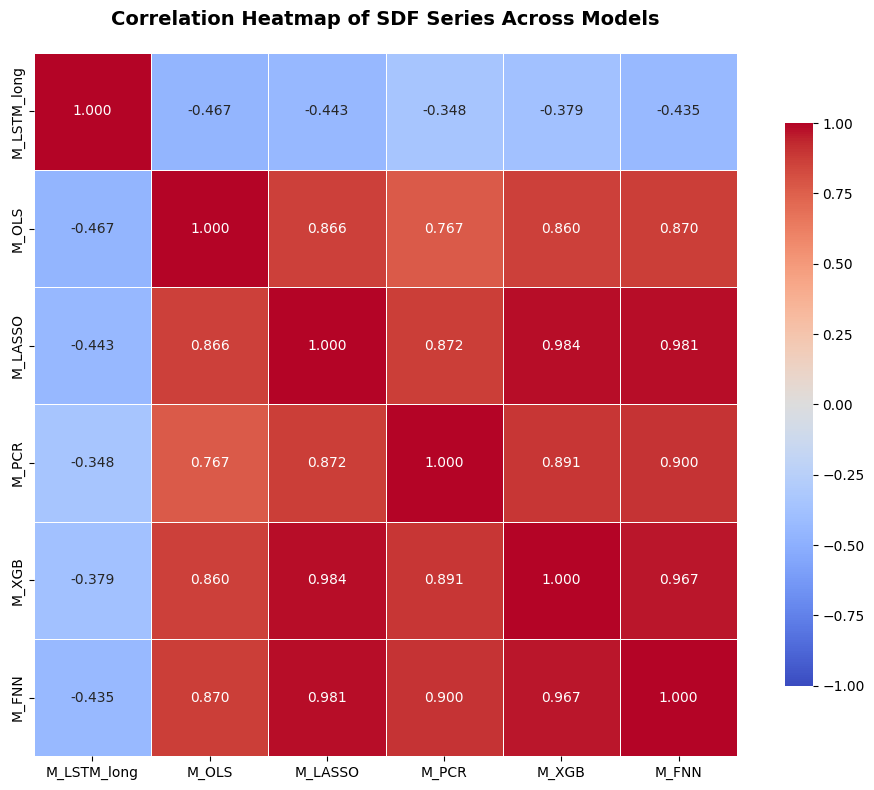


Correlation Matrix:
             M_LSTM_long     M_OLS   M_LASSO     M_PCR     M_XGB     M_FNN
M_LSTM_long     1.000000 -0.467494 -0.443021 -0.348027 -0.378637 -0.435172
M_OLS          -0.467494  1.000000  0.865886  0.767478  0.860403  0.869988
M_LASSO        -0.443021  0.865886  1.000000  0.872145  0.984230  0.980760
M_PCR          -0.348027  0.767478  0.872145  1.000000  0.890917  0.899554
M_XGB          -0.378637  0.860403  0.984230  0.890917  1.000000  0.967230
M_FNN          -0.435172  0.869988  0.980760  0.899554  0.967230  1.000000


In [43]:
# Correlation Heatmap of SDF Series
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation matrix
corr_matrix = sdf_df.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt='.3f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            vmin=-1, 
            vmax=1)

plt.title('Correlation Heatmap of SDF Series Across Models', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Also display the correlation matrix as a table
print("\nCorrelation Matrix:")
print(corr_matrix)

In [44]:
#==============================================================================
# BUILD RETURNS PANEL ALIGNED WITH SDF DATES
#==============================================================================

# Get SDF dates from sdf_df index
sdf_dates = sdf_df.index.tolist()
print(f"SDF dates: {len(sdf_dates)} dates from {sdf_dates[0]} to {sdf_dates[-1]}")

# Filter panel_for_cov to SDF dates and compute excess returns
panel_filtered = panel_for_cov[panel_for_cov['date'].isin(sdf_dates)].copy()

# Compute excess returns: rexcess = ret - rf
if 'rf' in panel_filtered.columns:
    panel_filtered['rexcess'] = panel_filtered['ret'] - panel_filtered['rf']
else:
    print("Warning: 'rf' column not found. Using raw returns as rexcess.")
    panel_filtered['rexcess'] = panel_filtered['ret']

# Create panel with MultiIndex (date, comp_name) and rexcess column
panel = panel_filtered.set_index(['date', 'comp_name'])[['rexcess']].copy()
panel.name = 'panel'

print(f"\nReturns panel created:")
print(f"  Shape: {panel.shape}")
print(f"  Date range: {panel.index.get_level_values('date').min()} to {panel.index.get_level_values('date').max()}")
print(f"  Number of firms: {panel.index.get_level_values('comp_name').nunique()}")
print(f"\nSample of panel:")
print(panel.head(10))

#==============================================================================
# MERGE SDF KERNELS WITH RETURNS PANEL
#==============================================================================

# Reset sdf_df index to have 'date' as a column for merging
sdf_kernels = sdf_df.reset_index()

# Merge panel with SDF kernels by date
# This will add all SDF kernel columns to each (date, firm) observation
merged = panel.reset_index().merge(
    sdf_kernels,
    on='date',
    how='inner'  # Keep only dates that exist in both
)

# Set MultiIndex back to (date, comp_name)
merged = merged.set_index(['date', 'comp_name'])

print(f"\nMerged panel:")
print(f"  Shape: {merged.shape}")
print(f"  Columns: {list(merged.columns)}")
print(f"\nSample of merged data:")
print(merged.head(10))

# Store the merged panel
panel_merged = merged

SDF dates: 138 dates from 2013-02-01 00:00:00 to 2024-12-01 00:00:00

Returns panel created:
  Shape: (65655, 1)
  Date range: 2013-02-01 00:00:00 to 2024-12-01 00:00:00
  Number of firms: 749

Sample of panel:
                       rexcess
date       comp_name          
2013-02-01 3M CO      0.039890
2013-03-01 3M CO      0.021969
2013-04-01 3M CO     -0.015167
2013-05-01 3M CO      0.057454
2013-06-01 3M CO     -0.008378
2013-07-01 3M CO      0.071290
2013-08-01 3M CO     -0.027752
2013-09-01 3M CO      0.050055
2013-10-01 3M CO      0.052529
2013-11-01 3M CO      0.063989

Merged panel:
  Shape: (65655, 7)
  Columns: ['rexcess', 'M_LSTM_long', 'M_OLS', 'M_LASSO', 'M_PCR', 'M_XGB', 'M_FNN']

Sample of merged data:
                       rexcess  M_LSTM_long     M_OLS   M_LASSO     M_PCR  \
date       comp_name                                                        
2013-02-01 3M CO      0.039890     1.003874  0.996759  0.997944  1.000614   
2013-03-01 3M CO      0.021969     1.00494

In [45]:
#==============================================================================
# CALCULATE SDF EXPOSURES PER FIRM (Time Series Regression)
#==============================================================================

import statsmodels.api as sm
from functools import reduce

def exposures_for_model(panel, kernel_col, firm_col='comp_name', ret_col='rexcess', min_obs=24):
    """
    Calculate SDF exposure (beta) for each firm via time series regression.
    
    For each firm, runs: rexcess_t = alpha + beta * M_t + epsilon_t
    Uses HAC standard errors to account for heteroskedasticity and autocorrelation.
    
    Parameters:
    -----------
    panel : pd.DataFrame
        Panel with MultiIndex (date, comp_name) containing ret_col and kernel_col
    kernel_col : str
        Name of SDF kernel column (e.g., 'M_LSTM_long')
    firm_col : str
        Name of firm identifier (for output, not used in grouping if MultiIndex)
    ret_col : str
        Name of excess returns column
    min_obs : int
        Minimum number of observations required per firm
        
    Returns:
    --------
    pd.DataFrame with columns: [firm_col, beta_{kernel_col}, t_{kernel_col}, n_obs]
    """
    out = []
    
    # Group by firm (use level='comp_name' for MultiIndex)
    for firm, g in panel[[ret_col, kernel_col]].dropna().groupby(level='comp_name'):
        if len(g) < min_obs:
            continue
            
        y = g[ret_col].values
        x = sm.add_constant(g[kernel_col].values)
        
        # OLS regression with HAC standard errors
        res = sm.OLS(y, x).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
        
        out.append({
            firm_col: firm,
            f'beta_{kernel_col}': res.params[1],
            f't_{kernel_col}': res.tvalues[1],
            'n_obs': len(g)
        })
    
    return pd.DataFrame(out)

# Calculate exposures for each SDF kernel
print("Calculating SDF exposures per firm...")
print("=" * 70)

# Get all SDF kernel columns (exclude 'rexcess')
sdf_kernel_cols = [col for col in panel_merged.columns if col.startswith('M_')]
print(f"SDF kernel columns: {sdf_kernel_cols}")

exposure_tables = []
for col in sdf_kernel_cols:
    print(f"\nProcessing {col}...")
    exposures = exposures_for_model(panel_merged, col, min_obs=24)
    exposure_tables.append(exposures)
    print(f"  Firms with sufficient data: {len(exposures)}")

# Merge exposures across all models
print("\n" + "=" * 70)
print("Merging exposures across models...")

# Keep n_obs only from the first table (they should all be the same)
# Drop n_obs from subsequent tables to avoid merge conflicts
for i in range(1, len(exposure_tables)):
    if 'n_obs' in exposure_tables[i].columns:
        exposure_tables[i] = exposure_tables[i].drop(columns=['n_obs'])

exposures_df = reduce(
    lambda left, right: left.merge(right, on='comp_name', how='outer'), 
    exposure_tables
)

print(f"\nFinal exposures DataFrame:")
print(f"  Shape: {exposures_df.shape}")
print(f"  Firms: {len(exposures_df)}")
print(f"\nColumns: {list(exposures_df.columns)}")
print(f"\nSample of exposures:")
print(exposures_df.head(10))

# Summary statistics
print("\n" + "=" * 70)
print("EXPOSURE SUMMARY STATISTICS")
print("=" * 70)

beta_cols = [col for col in exposures_df.columns if col.startswith('beta_')]
t_cols = [col for col in exposures_df.columns if col.startswith('t_')]

print("\nBeta coefficients:")
print(exposures_df[beta_cols].describe())

print("\nT-statistics:")
print(exposures_df[t_cols].describe())

Calculating SDF exposures per firm...
SDF kernel columns: ['M_LSTM_long', 'M_OLS', 'M_LASSO', 'M_PCR', 'M_XGB', 'M_FNN']

Processing M_LSTM_long...
  Firms with sufficient data: 692

Processing M_OLS...
  Firms with sufficient data: 692

Processing M_LASSO...
  Firms with sufficient data: 692

Processing M_PCR...
  Firms with sufficient data: 692

Processing M_XGB...
  Firms with sufficient data: 692

Processing M_FNN...
  Firms with sufficient data: 692

Merging exposures across models...

Final exposures DataFrame:
  Shape: (692, 14)
  Firms: 692

Columns: ['comp_name', 'beta_M_LSTM_long', 't_M_LSTM_long', 'n_obs', 'beta_M_OLS', 't_M_OLS', 'beta_M_LASSO', 't_M_LASSO', 'beta_M_PCR', 't_M_PCR', 'beta_M_XGB', 't_M_XGB', 'beta_M_FNN', 't_M_FNN']

Sample of exposures:
               comp_name  beta_M_LSTM_long  t_M_LSTM_long  n_obs  beta_M_OLS  \
0                  3M CO          0.653313       0.473478    138    1.049062   
1             A D T CORP         -5.957812      -2.154205     32

In [46]:
#==============================================================================
# CALCULATE PRICING ERRORS (ALPHAS) FOR EACH FIRM AND MODEL
#==============================================================================

print("=" * 70)
print("CALCULATING PRICING ERRORS (ALPHAS)")
print("=" * 70)

# Get all SDF kernel columns (exclude 'rexcess')
sdf_kernel_cols = [col for col in panel_merged.columns if col.startswith('M_')]
print(f"\nSDF kernel columns: {sdf_kernel_cols}")

# Calculate pricing errors (alphas) for each model
pricing_errors = []

for col in sdf_kernel_cols:
    # Reset index to have 'date' and 'comp_name' as columns for easier manipulation
    tmp = panel_merged.reset_index()[['comp_name', 'rexcess', col]].dropna()
    
    # Calculate MR (marginal rate): SDF * excess return
    tmp['MR'] = tmp[col] * tmp['rexcess']
    
    # Group by firm and calculate mean MR (this is the alpha/pricing error)
    pe = tmp.groupby('comp_name')['MR'].mean().rename(f'alpha_{col}')
    pricing_errors.append(pe)
    
    print(f"\n{col}:")
    print(f"  Firms with data: {len(pe)}")
    print(f"  Mean alpha: {pe.mean():.6f}")
    print(f"  Std alpha: {pe.std():.6f}")

# Concatenate all pricing errors into a single DataFrame
alphas_df = pd.concat(pricing_errors, axis=1).reset_index()

print(f"\n" + "=" * 70)
print(f"PRICING ERRORS SUMMARY")
print("=" * 70)
print(f"\nFinal alphas DataFrame:")
print(f"  Shape: {alphas_df.shape}")
print(f"  Firms: {len(alphas_df)}")
print(f"\nColumns: {list(alphas_df.columns)}")
print(f"\nSample of alphas:")
print(alphas_df.head(10))

# Summary statistics
print(f"\n" + "=" * 70)
print("ALPHA SUMMARY STATISTICS")
print("=" * 70)

alpha_cols = [col for col in alphas_df.columns if col.startswith('alpha_')]
print("\nAlpha statistics by model:")
print(alphas_df[alpha_cols].describe())

alphas_df

CALCULATING PRICING ERRORS (ALPHAS)

SDF kernel columns: ['M_LSTM_long', 'M_OLS', 'M_LASSO', 'M_PCR', 'M_XGB', 'M_FNN']

M_LSTM_long:
  Firms with data: 749
  Mean alpha: 0.004503
  Std alpha: 0.014545

M_OLS:
  Firms with data: 749
  Mean alpha: 0.004646
  Std alpha: 0.014464

M_LASSO:
  Firms with data: 749
  Mean alpha: 0.004777
  Std alpha: 0.014422

M_PCR:
  Firms with data: 749
  Mean alpha: 0.004726
  Std alpha: 0.014457

M_XGB:
  Firms with data: 749
  Mean alpha: 0.004753
  Std alpha: 0.014428

M_FNN:
  Firms with data: 749
  Mean alpha: 0.004741
  Std alpha: 0.014438

PRICING ERRORS SUMMARY

Final alphas DataFrame:
  Shape: (749, 7)
  Firms: 749

Columns: ['comp_name', 'alpha_M_LSTM_long', 'alpha_M_OLS', 'alpha_M_LASSO', 'alpha_M_PCR', 'alpha_M_XGB', 'alpha_M_FNN']

Sample of alphas:
                comp_name  alpha_M_LSTM_long  alpha_M_OLS  alpha_M_LASSO  \
0                   3M CO           0.004825     0.004868       0.004957   
1              A D T CORP           0.00461

,comp_name,alpha_M_LSTM_long,alpha_M_OLS,alpha_M_LASSO,alpha_M_PCR,alpha_M_XGB,alpha_M_FNN
0,3M CO,0.004825,0.004868,0.004957,0.004880,0.004931,0.004917
1,A D T CORP,0.004616,0.004848,0.004914,0.004895,0.004898,0.004823
2,A E S CORP,0.002640,0.002705,0.002825,0.002742,0.002828,0.002777
3,A G L RESOURCES INC,0.013999,0.013958,0.013925,0.013888,0.013914,0.013931
4,A P A CORP,-0.003876,-0.003997,-0.003793,-0.003804,-0.003787,-0.003769
...,...,...,...,...,...,...,...
744,ZIMMER BIOMET HOLDINGS INC,-0.002682,-0.002422,-0.002210,-0.002344,-0.002247,-0.002266
745,ZIMMER HOLDINGS INC,0.016244,0.016177,0.016212,0.016228,0.016198,0.016201
746,ZIONS BANCORPORATION,0.014946,0.015072,0.015075,0.015160,0.015080,0.015084
747,ZIONS BANCORPORATION N A,-0.002521,-0.002017,-0.001477,-0.001684,-0.001546,-0.001614


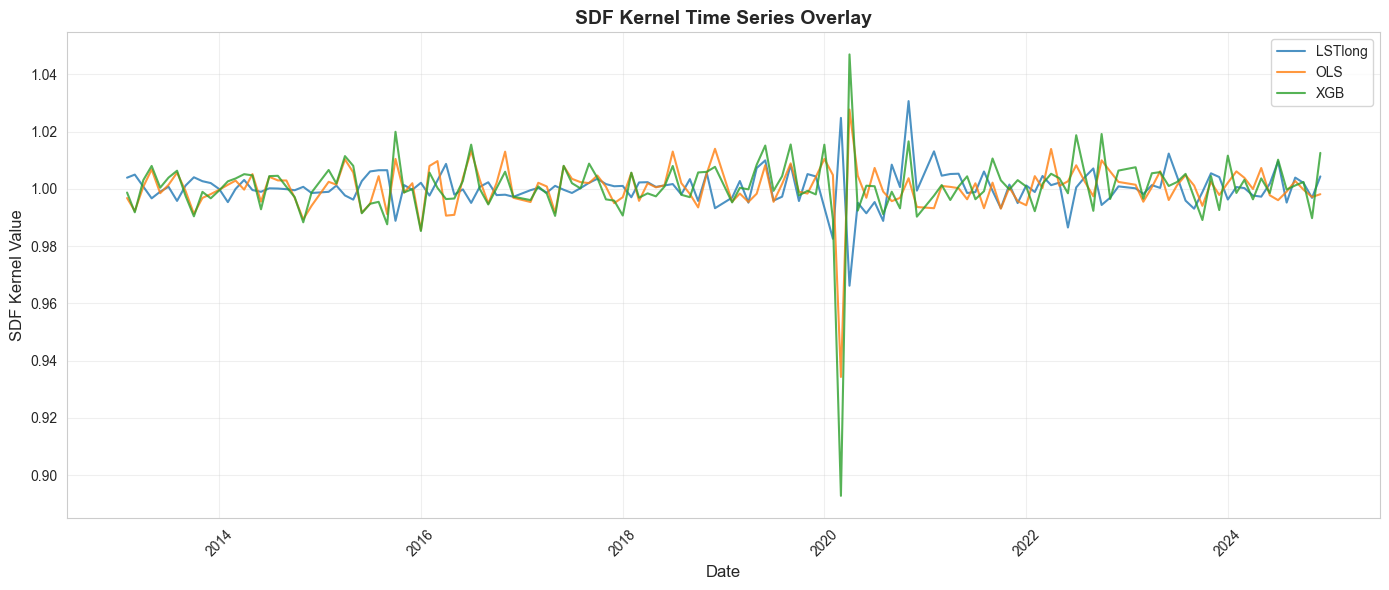

In [47]:
#==============================================================================
# PLOT 1: KERNEL TIME SERIES OVERLAY (2-3 models)
#==============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Select 2-3 models to plot (e.g., LSTM_long, OLS, and one more)
models_to_plot = ['M_LSTM_long', 'M_OLS', 'M_XGB']  # Adjust as needed
available_models = [m for m in models_to_plot if m in sdf_df.columns]

if len(available_models) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    for model in available_models:
        ax.plot(sdf_df.index, sdf_df[model], label=model.replace('M_', ''), linewidth=1.5, alpha=0.8)
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('SDF Kernel Value', fontsize=12)
    ax.set_title('SDF Kernel Time Series Overlay', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No models available to plot")

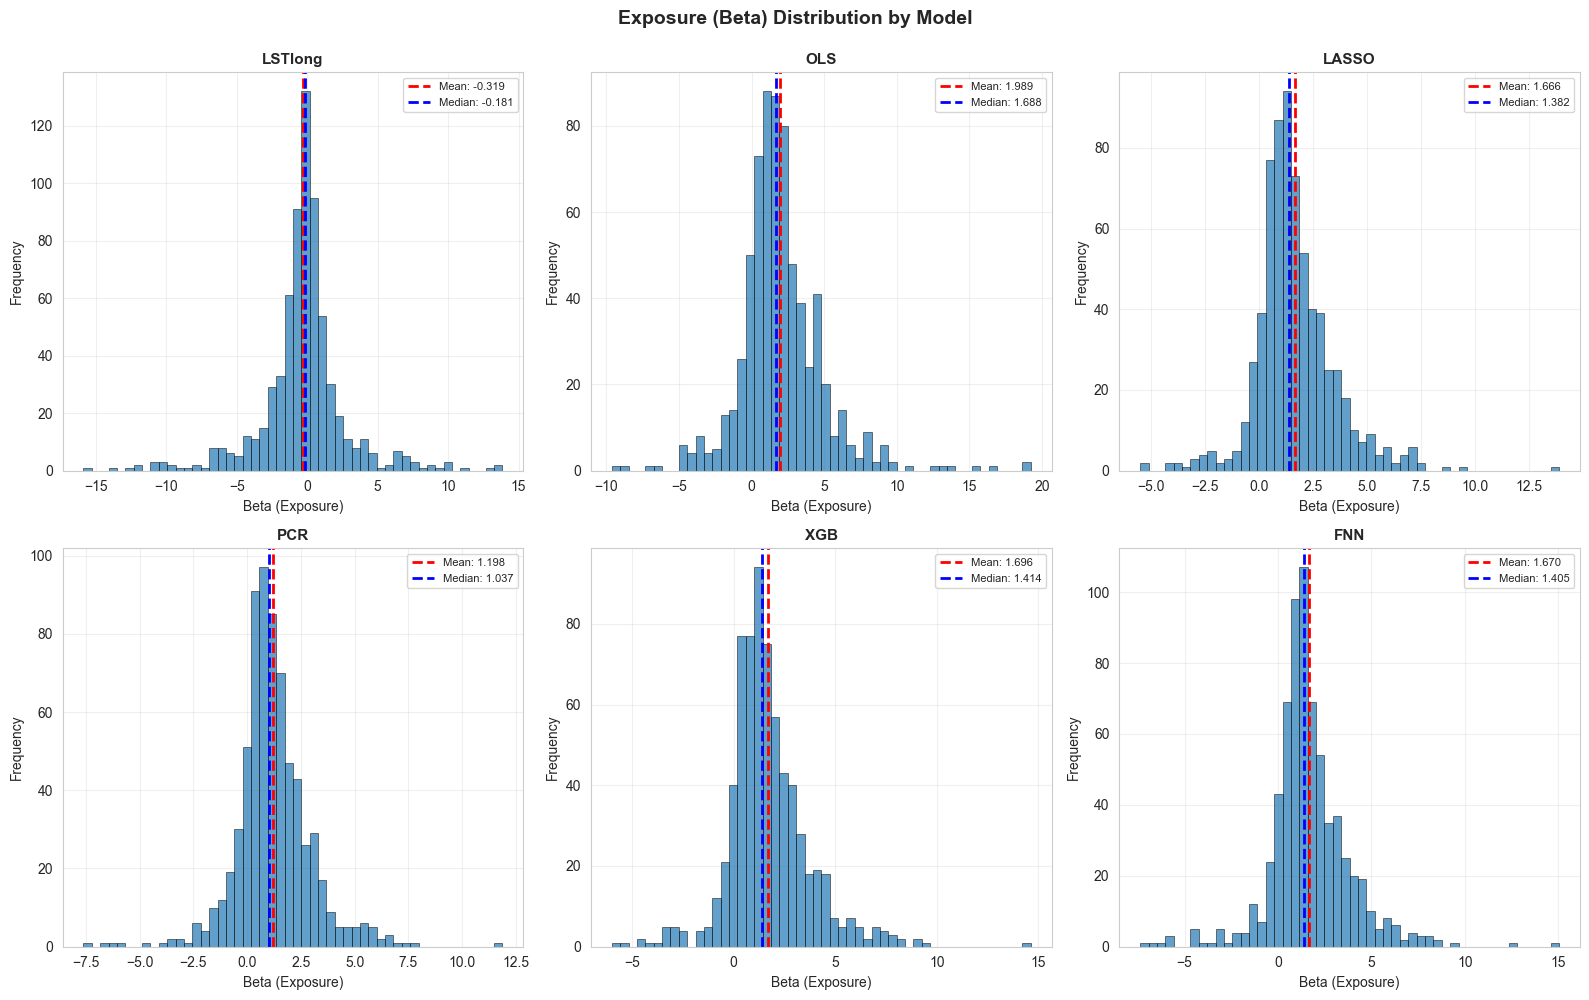

In [48]:
#==============================================================================
# PLOT 2: EXPOSURE DISTRIBUTION BY MODEL
#==============================================================================

# Get beta columns
beta_cols = [col for col in exposures_df.columns if col.startswith('beta_')]

if len(beta_cols) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, beta_col in enumerate(beta_cols):
        if idx < len(axes):
            data = exposures_df[beta_col].dropna()
            model_name = beta_col.replace('beta_', '').replace('M_', '')
            
            axes[idx].hist(data, bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)
            axes[idx].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.3f}')
            axes[idx].axvline(data.median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {data.median():.3f}')
            axes[idx].set_xlabel('Beta (Exposure)', fontsize=10)
            axes[idx].set_ylabel('Frequency', fontsize=10)
            axes[idx].set_title(f'{model_name}', fontsize=11, fontweight='bold')
            axes[idx].legend(fontsize=8)
            axes[idx].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(beta_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Exposure (Beta) Distribution by Model', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
else:
    print("No beta columns found in exposures_df")

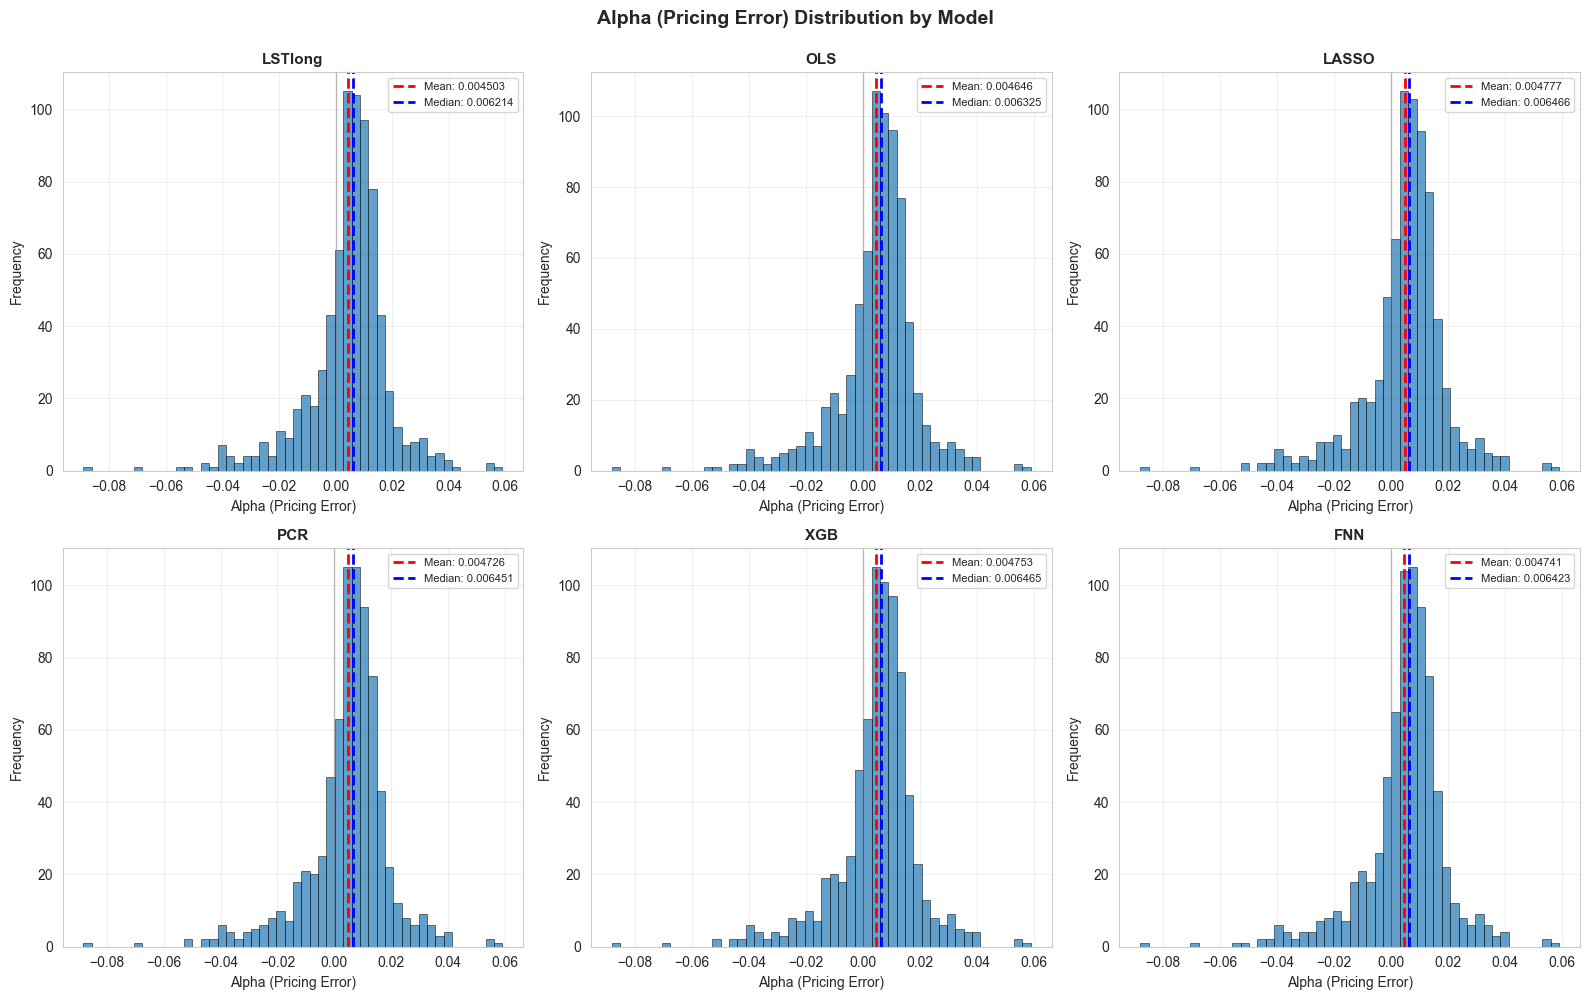

In [49]:
#==============================================================================
# PLOT 3: ALPHA DISTRIBUTION BY MODEL
#==============================================================================

# Get alpha columns
alpha_cols = [col for col in alphas_df.columns if col.startswith('alpha_')]

if len(alpha_cols) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, alpha_col in enumerate(alpha_cols):
        if idx < len(axes):
            data = alphas_df[alpha_col].dropna()
            model_name = alpha_col.replace('alpha_', '').replace('M_', '')
            
            axes[idx].hist(data, bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)
            axes[idx].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.6f}')
            axes[idx].axvline(data.median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {data.median():.6f}')
            axes[idx].axvline(0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
            axes[idx].set_xlabel('Alpha (Pricing Error)', fontsize=10)
            axes[idx].set_ylabel('Frequency', fontsize=10)
            axes[idx].set_title(f'{model_name}', fontsize=11, fontweight='bold')
            axes[idx].legend(fontsize=8)
            axes[idx].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(alpha_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Alpha (Pricing Error) Distribution by Model', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
else:
    print("No alpha columns found in alphas_df")

In [50]:
#==============================================================================
# TABLE 1: SUMMARY STATISTICS OF M (SDF KERNELS)
#==============================================================================

# Get all SDF kernel columns
sdf_kernel_cols = [col for col in sdf_df.columns if col.startswith('M_')]

if len(sdf_kernel_cols) > 0:
    # Calculate summary statistics
    summary_stats = sdf_df[sdf_kernel_cols].describe().T
    
    # Add additional statistics
    summary_stats['skewness'] = sdf_df[sdf_kernel_cols].skew()
    summary_stats['kurtosis'] = sdf_df[sdf_kernel_cols].kurtosis()
    
    # Rename index to remove 'M_' prefix for cleaner display
    summary_stats.index = [idx.replace('M_', '') for idx in summary_stats.index]
    
    # Reorder columns for better readability
    col_order = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis']
    summary_stats = summary_stats[col_order]
    
    print("=" * 70)
    print("SUMMARY STATISTICS OF SDF KERNELS (M)")
    print("=" * 70)
    print("\n")
    print(summary_stats.round(6))
    print("\n")
    summary_stats
else:
    print("No SDF kernel columns found in sdf_df")

SUMMARY STATISTICS OF SDF KERNELS (M)


         count      mean       std       min       25%       50%       75%  \
LSTlong  138.0  1.000386  0.006377  0.966139  0.997651  1.000384  1.002859   
OLS      138.0  1.000354  0.008190  0.934256  0.996810  1.000891  1.004038   
LASSO    138.0  1.000614  0.012800  0.893408  0.996859  1.000517  1.004686   
PCR      138.0  1.000268  0.013146  0.895856  0.994990  0.999375  1.004703   
XGB      138.0  1.000534  0.012083  0.892735  0.996729  1.000359  1.005181   
FNN      138.0  1.000423  0.011601  0.903922  0.996906  1.000171  1.003673   

              max  skewness   kurtosis  
LSTlong  1.030626 -0.120415  10.104670  
OLS      1.027676 -3.524748  30.850947  
LASSO    1.068474 -3.188256  40.778246  
PCR      1.053351 -3.013808  30.174022  
XGB      1.046939 -4.730812  47.257118  
FNN      1.060840 -3.132719  39.427233  




In [51]:
#==============================================================================
# TABLE 2: MEAN(|ALPHA|) AND MEDIAN(|ALPHA|) PER MODEL
#==============================================================================

# Get alpha columns
alpha_cols = [col for col in alphas_df.columns if col.startswith('alpha_')]

if len(alpha_cols) > 0:
    # Calculate mean and median of absolute alphas
    alpha_summary = pd.DataFrame({
        'Model': [col.replace('alpha_', '').replace('M_', '') for col in alpha_cols],
        'Mean(|Alpha|)': [alphas_df[col].abs().mean() for col in alpha_cols],
        'Median(|Alpha|)': [alphas_df[col].abs().median() for col in alpha_cols],
        'Std(|Alpha|)': [alphas_df[col].abs().std() for col in alpha_cols],
        'Min(|Alpha|)': [alphas_df[col].abs().min() for col in alpha_cols],
        'Max(|Alpha|)': [alphas_df[col].abs().max() for col in alpha_cols],
        'N_Firms': [alphas_df[col].notna().sum() for col in alpha_cols]
    })
    
    # Sort by Mean(|Alpha|) for easier comparison
    alpha_summary = alpha_summary.sort_values('Mean(|Alpha|)', ascending=False).reset_index(drop=True)
    
    print("=" * 70)
    print("SUMMARY STATISTICS OF ABSOLUTE ALPHAS BY MODEL")
    print("=" * 70)
    print("\n")
    print(alpha_summary.to_string(index=False))
    print("\n")
    alpha_summary
else:
    print("No alpha columns found in alphas_df")

SUMMARY STATISTICS OF ABSOLUTE ALPHAS BY MODEL


  Model  Mean(|Alpha|)  Median(|Alpha|)  Std(|Alpha|)  Min(|Alpha|)  Max(|Alpha|)  N_Firms
  LASSO       0.011467         0.009201      0.009959      0.000028      0.088016      749
    PCR       0.011463         0.009188      0.009989      0.000006      0.088228      749
    FNN       0.011461         0.009232      0.009971      0.000038      0.087903      749
    XGB       0.011459         0.009180      0.009966      0.000073      0.088179      749
    OLS       0.011433         0.009178      0.009997      0.000052      0.088257      749
LSTlong       0.011418         0.009126      0.010066      0.000009      0.089087      749


